In [240]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import cross_validate
import timeit
from sklearn.model_selection import train_test_split

#working directory is the one with dataset
os.chdir(r'C:/Users/xpj/Desktop/OMSCS/CS7641/HW/HW3')

In [241]:
#load data

#1
df_mkt = pd.read_csv("bank-full.csv")
#set column datatype
cate_cols = ['job','marital','education','default','housing','loan','contact','month','day','poutcome']
df_dummies = pd.get_dummies(df_mkt[cate_cols]).astype('category') #set dummy variables as binary
df_drop_cate_cols = df_mkt.drop(cate_cols, axis=1)
df_mkt = pd.concat([df_dummies,df_drop_cate_cols],axis = 1)

df_mkt['y'].replace("no",0,inplace=True)
df_mkt['y'].replace("yes",1,inplace=True)
df_mkt['y'] = df_mkt['y'].astype("category")
#normalize numeric columns
num_cols = ['age','balance','duration','campaign','pdays','previous']
for i in num_cols:
    df_mkt[i]=(df_mkt[i] - df_mkt[i].min())/(df_mkt[i].max() - df_mkt[i].min())

#2
df_wine = pd.read_csv("wineQualityReds.csv")

num_col = df_wine.shape[1]
i = 0
while i < num_col:
    df_wine.iloc[:,i]=(df_wine.iloc[:,i] - df_wine.iloc[:,i].min())/(df_wine.iloc[:,i].max() - df_wine.iloc[:,i].min())
    i = i+1

    
def load_xy():
    x = np.array(df_mkt.values[:,0:-1])
    y = np.array(df_mkt.values[:,-1],dtype='int64')
    return x,y

def load_xy2():
    x = np.array(df_wine.values[:,0:-1])
    y = np.array(df_wine.values[:,-1],dtype='int64')
    return x,y

df_mkt_x, df_mkt_y = load_xy()
df_wine_x, df_wine_y = load_xy2()

In [242]:
import numpy as np
import scipy
from scipy.linalg import pinv
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA, TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples, mean_squared_error
from sklearn.random_projection import GaussianRandomProjection
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

from numpy import linalg as LA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D



import itertools
import scipy.stats

import time


In [244]:
range_n_clusters = np.arange(1,11,1)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=2)
    k_means_clustering.fit(df_mkt_x)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)

range_n_clusters_wine = np.arange(1,21,1)
inertia_wine = []
for n_clusters in range_n_clusters_wine:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=2)
    k_means_clustering.fit(df_wine_x)
    inertia_wine.append(k_means_clustering.inertia_)
inertia_wine = np.array(inertia_wine)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


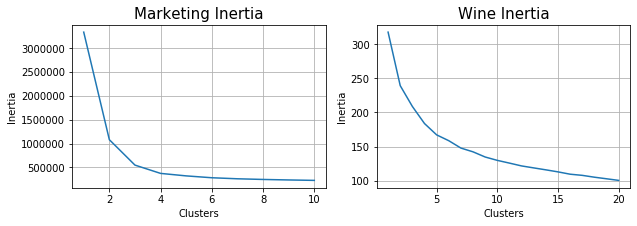

In [250]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(3)
fig.set_figwidth(10)
# fig.suptitle('kmeans cluster - inertia',fontsize=20)

fig.savefig("kmeans-cluster") 


ax1.plot(range_n_clusters,inertia)
ax1.set_xlabel('Clusters',fontsize=10)
ax1.set_ylabel('Inertia',fontsize=10)
ax1.set_title('Marketing Inertia',fontsize=15)
ax1.grid()

ax2.plot(range_n_clusters_wine,inertia_wine)
ax2.set_xlabel('Clusters',fontsize=10)
ax2.set_ylabel('Inertia',fontsize=10)
ax2.set_title('Wine Inertia',fontsize=15)
ax2.grid()
fig.savefig('kmeans_inertia.png')
fig.show()

For n_clusters = 2 The average silhouette_score is : 0.5339629125625432 The average homogeneity_score is : 0.0020740692923103096 The average completeness_score is : 0.0010804947630679196 The average v_measure_score is : 0.001420811858146009
For n_clusters = 3 The average silhouette_score is : 0.5027434345163635 The average homogeneity_score is : 0.0005903814148302316 The average completeness_score is : 0.0002003379550504824 The average v_measure_score is : 0.00029916000505904376
For n_clusters = 4 The average silhouette_score is : 0.44106501104288637 The average homogeneity_score is : 0.003636415009043337 The average completeness_score is : 0.0009540650628583584 The average v_measure_score is : 0.0015115528048658983


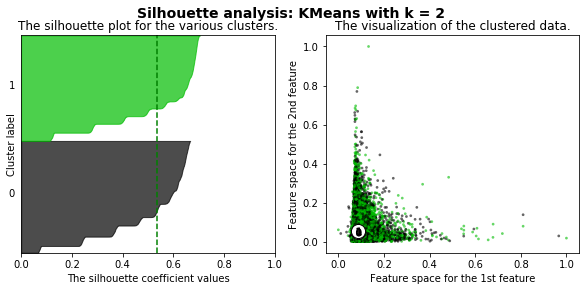

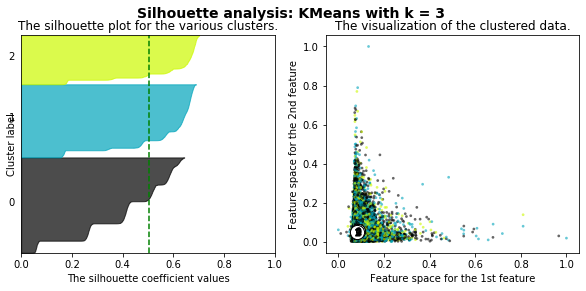

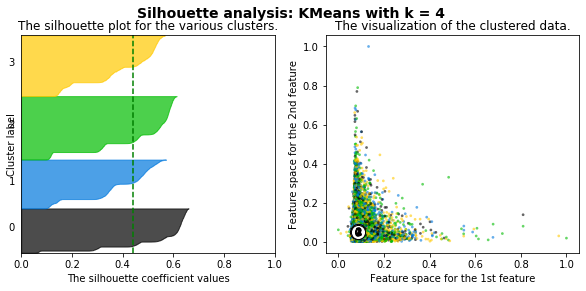

In [252]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

# https://medium.com/@cmukesh8688/silhouette-analysis-in-k-means-clustering-cefa9a7ad111
# https://towardsdatascience.com/when-clustering-doesnt-make-sense-c6ed9a89e9e6


range_n_clusters = np.arange(2, 5, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10,4)

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_mkt_x) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(df_mkt_x)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_mkt_x, cluster_labels)
    homogeneity_avg = homogeneity_score(df_mkt_y, cluster_labels)
    completeness_avg = completeness_score(df_mkt_y, cluster_labels)
    v_avg = v_measure_score(df_mkt_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_mkt_x, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        df_mkt_x[:, -5], df_mkt_x[:, -4], marker=".", s=30, lw=0, alpha=0.6, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, -5],
        centers[:, -4],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[-5], c[-4], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    fig.suptitle(
        "Silhouette analysis: KMeans with k = %d"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('mkt_kmeans_silhouette.png')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.244504730670136 The average homogeneity_score is : 0.03202366196643109 The average completeness_score is : 0.03263258667649123 The average v_measure_score is : 0.032325256931917956
For n_clusters = 3 The average silhouette_score is : 0.21098640259521592 The average homogeneity_score is : 0.05834788492727503 The average completeness_score is : 0.03771957654163459 The average v_measure_score is : 0.0458190000631817


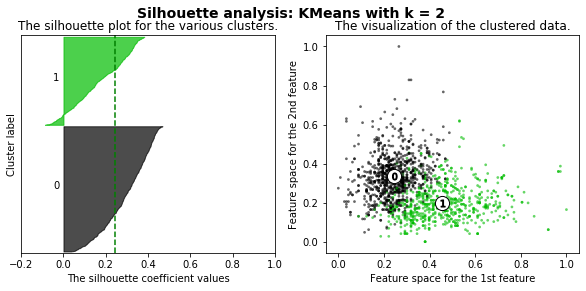

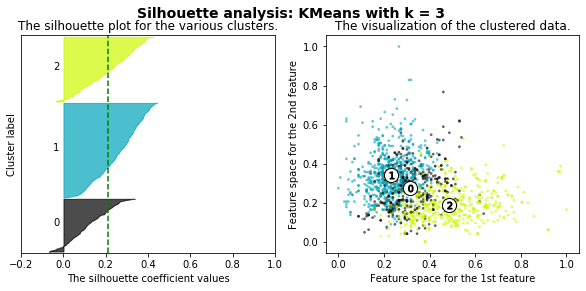

In [253]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

range_n_clusters = np.arange(2,4, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10,4)

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_wine_x) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(df_wine_x)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_wine_x, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_wine_x, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        df_wine_x[:, 0], df_wine_x[:, 1], marker=".", s=30, lw=0, alpha=0.6, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    fig.suptitle(
        "Silhouette analysis: KMeans with k = %d"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('wine_kmeans_silhouette.png')
plt.show()

Inertia:  549070.9439069999
Silhouette score:  0.5027434345163635
Adjusted Mutual Information (AMI) score:  0.00017954035266598212


D:\Anaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


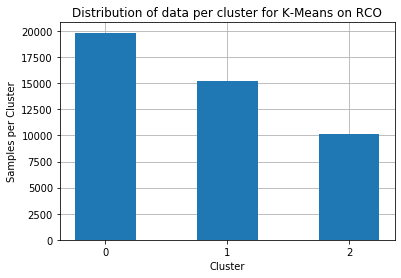

In [21]:
k = 3
k_means_clustering = KMeans(n_clusters=k, random_state=2)
k_means_clustering.fit(df_mkt_x)
print('Inertia: ', k_means_clustering.inertia_)
silhouette_score_value = silhouette_score(df_mkt_x, k_means_clustering.labels_)
print('Silhouette score: ', silhouette_score_value)
adjusted_mutual_info_score_value = adjusted_mutual_info_score(df_mkt_y, k_means_clustering.labels_)
print('Adjusted Mutual Information (AMI) score: ', adjusted_mutual_info_score_value)

plt.figure()
plt.hist(k_means_clustering.labels_, bins=np.arange(0, k + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, k))
plt.xlabel('Cluster')
plt.ylabel('Samples per Cluster')
plt.title('Distribution of data per cluster for K-Means on RCO')
plt.grid()

Inertia:  239.1831102994267
Silhouette score:  0.244504730670136
Adjusted Mutual Information (AMI) score:  0.031584829550450236


D:\Anaconda\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


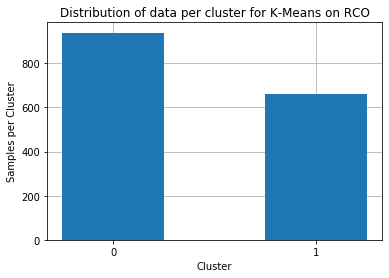

In [23]:
k = 2
k_means_clustering = KMeans(n_clusters=k, random_state=2)
k_means_clustering.fit(df_wine_x)
print('Inertia: ', k_means_clustering.inertia_)
silhouette_score_value = silhouette_score(df_wine_x, k_means_clustering.labels_)
print('Silhouette score: ', silhouette_score_value)
adjusted_mutual_info_score_value = adjusted_mutual_info_score(df_wine_y, k_means_clustering.labels_)
print('Adjusted Mutual Information (AMI) score: ', adjusted_mutual_info_score_value)

plt.figure()
plt.hist(k_means_clustering.labels_, bins=np.arange(0, k + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, k))
plt.xlabel('Cluster')
plt.ylabel('Samples per Cluster')
plt.title('Distribution of data per cluster for K-Means on RCO')
plt.grid()


In [ ]:
import numpy
import sys
numpy.set_printoptions(threshold=sys.maxsize)
print(1-cluster_labels)

In [255]:
##EM
#https://pythonmachinelearning.pro/clustering-with-gaussian-mixture-models/
# https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4

# https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
# https://pythonmachinelearning.pro/clustering-with-gaussian-mixture-models/

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture



degree_mkt = df_mkt_x.shape[1]
# gmm = GaussianMixture(n_components=degree_mkt)
# gmm.fit(df_mkt_x)
# print(gmm.means_)
# print('\n')
# print(gmm.covariances_)

lowest_bic = np.infty
num_components_values = range(1, degree_mkt+1,1)
covariances = ['spherical', 'tied', 'diag', 'full']
bic = np.zeros((len(covariances),len(num_components_values)))
for i, covariance in enumerate(covariances):
    for j, num_components in enumerate(num_components_values):
        gmm = mixture.GaussianMixture(n_components=num_components, covariance_type=covariance)
        gmm.fit(df_mkt_x)
        bic[i][j] = gmm.bic(df_mkt_x)
        if bic[i][j] < lowest_bic:
            lowest_bic = bic[i][j]
            print("Lowest BIC currently for", covariance, num_components)
            best_gmm = gmm

Lowest BIC currently for spherical 1
Lowest BIC currently for spherical 2
Lowest BIC currently for spherical 3
Lowest BIC currently for spherical 4
Lowest BIC currently for spherical 5
Lowest BIC currently for spherical 6
Lowest BIC currently for spherical 7
Lowest BIC currently for spherical 8
Lowest BIC currently for spherical 9
Lowest BIC currently for spherical 10
Lowest BIC currently for spherical 12
Lowest BIC currently for spherical 13
Lowest BIC currently for spherical 14
Lowest BIC currently for spherical 15
Lowest BIC currently for spherical 16
Lowest BIC currently for spherical 17
Lowest BIC currently for spherical 18
Lowest BIC currently for spherical 19
Lowest BIC currently for spherical 20
Lowest BIC currently for spherical 21
Lowest BIC currently for spherical 22
Lowest BIC currently for spherical 23
Lowest BIC currently for spherical 24
Lowest BIC currently for spherical 25
Lowest BIC currently for spherical 26
Lowest BIC currently for spherical 27
Lowest BIC currently 

In [263]:
degree_wine = df_wine_x.shape[1]

lowest_bic = np.infty

num_components_values2 = range(1, degree_wine,1)
covariances = ['spherical', 'tied', 'diag', 'full']
bic2 = np.zeros((len(covariances),len(num_components_values2)))
for i, covariance in enumerate(covariances):
    for j, num_components in enumerate(num_components_values2):
        gmm = mixture.GaussianMixture(n_components=num_components, covariance_type=covariance)
        gmm.fit(df_wine_x)
        bic2[i][j] = gmm.bic(df_wine_x)
        if bic2[i][j] < lowest_bic:
            lowest_bic = bic[i][j]
            print("Lowest BIC currently for", covariance, num_components)
            best_gmm2 = gmm

Lowest BIC currently for spherical 1
Lowest BIC currently for spherical 2
Lowest BIC currently for spherical 3
Lowest BIC currently for spherical 4
Lowest BIC currently for spherical 5
Lowest BIC currently for spherical 6
Lowest BIC currently for spherical 7
Lowest BIC currently for spherical 8
Lowest BIC currently for spherical 9
Lowest BIC currently for spherical 10
Lowest BIC currently for tied 1


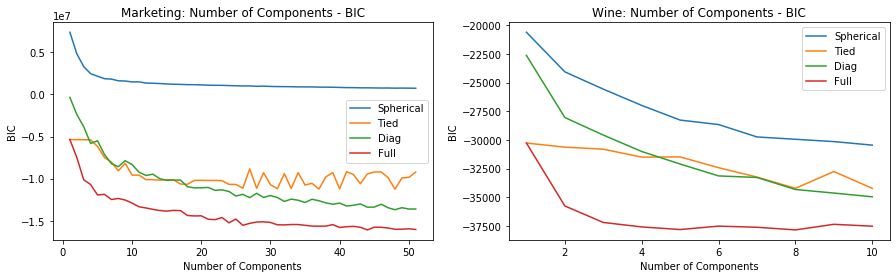

In [267]:
num_components_values = range(1, degree_mkt+1,1)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)

ax1.plot(num_components_values, bic[0], label = 'Spherical')
ax1.plot(num_components_values, bic[1], label = 'Tied')
ax1.plot(num_components_values, bic[2], label = 'Diag')
ax1.plot(num_components_values, bic[3], label = 'Full')
ax1.legend()
# ax1.xticks(range(1, degree_mkt,1))
ax1.set_title("Marketing: Number of Components - BIC")
ax1.set_xlabel("Number of Components")
ax1.set_ylabel("BIC")

ax2.plot(num_components_values2, bic2[0], label = 'Spherical')
ax2.plot(num_components_values2, bic2[1], label = 'Tied')
ax2.plot(num_components_values2, bic2[2], label = 'Diag')
ax2.plot(num_components_values2, bic2[3], label = 'Full')
ax2.legend()
# ax2.xticks(range(1, degree_mkt,5))
ax2.set_title("Wine: Number of Components - BIC")
ax2.set_xlabel("Number of Components")
ax2.set_ylabel("BIC")

fig.savefig('gmm_bic.png')


For n_clusters = 2 The average silhouette_score is : 0.0966541687094128 The average homogeneity_score is : 0.03399244785831763 The average completeness_score is : 0.021270770364366066 The average v_measure_score is : 0.026167334287461944
WINE For n_clusters = 2 The average silhouette_score is : 0.1708058718644838 The average homogeneity_score is : 0.001526728547379823 The average completeness_score is : 0.002209886467021381 The average v_measure_score is : 0.0018058573027548317


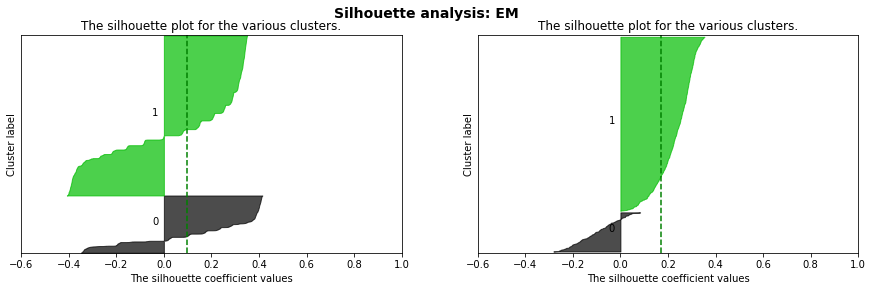

In [272]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

range_n_clusters = np.arange(2, 3, 1)

fig, (ax1,ax2) = plt.subplots(1, 2)
fig.set_size_inches(15,4)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns


    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_mkt_x) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(df_mkt_x)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_mkt_x, cluster_labels)
    homogeneity_avg = homogeneity_score(df_mkt_y, cluster_labels)
    completeness_avg = completeness_score(df_mkt_y, cluster_labels)
    v_avg = v_measure_score(df_mkt_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_mkt_x, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.6,-0.4,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])
    
#   WINE
 # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax2.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax2.set_ylim([0, len(df_wine_x) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(df_wine_x)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_wine_x, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "WINE",
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_wine_x, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax2.set_title("The silhouette plot for the various clusters.")
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax2.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.6,-0.4,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])


    fig.suptitle(
        "Silhouette analysis: EM"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('em_silhouette.png')
plt.show()

In [72]:
##PCA
# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis 
pca = PCA()
pca.fit(df_mkt_x)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

components
[9.99874460e-01 4.01593019e-04 1.13975676e-03 4.92512507e-05
 7.79292499e-05 9.36553431e-04 2.64813270e-04 1.12084200e-04
 2.28115053e-04 2.72371057e-04 1.46479905e-03 1.28435095e-04
 1.07030422e-04 1.68361957e-05 4.19540179e-04 4.02703983e-04
 8.46567853e-04 3.55509674e-04 1.19972296e-03 2.35456404e-06
 1.51013372e-04 1.51013372e-04 1.68806899e-03 1.68806899e-03
 5.05161929e-04 5.05161929e-04 1.17763092e-03 6.98717724e-04
 1.87634864e-03 1.41440461e-03 1.25851633e-03 9.37082880e-05
 7.99891511e-03 5.22052516e-03 6.37499668e-03 7.52739432e-03
 2.54481957e-04 1.40164215e-03 3.27100701e-03 4.64634941e-04
 7.27942910e-04 2.57427876e-03 7.84475587e-04 6.55628851e-04
 4.01438320e-03 1.50419268e-04 1.49918967e-05 1.89923430e-04
 9.75597667e-04 1.28696595e-03 5.21663898e-05]


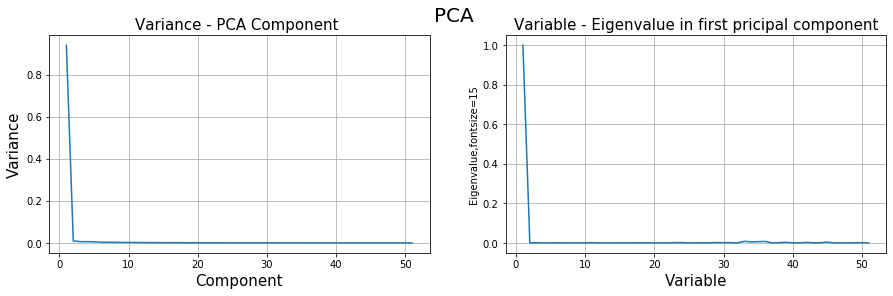

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle('PCA',fontsize=20)


ax1.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), pca.explained_variance_ratio_)
# plt.xticks(np.arange(1, pca.explained_variance_ratio_.size + 1))
ax1.set_xlabel('Component',fontsize=15)
ax1.set_ylabel('Variance',fontsize=15)
ax1.set_title('Variance - PCA Component ',fontsize=15)
ax1.grid()
ax2.plot(np.arange(1, pca.explained_variance_ratio_.size + 1),abs(pca.components_[0]))
ax2.set_xlabel('Variable',fontsize=15)
ax2.set_ylabel('Eigenvalue,fontsize=15')
ax2.set_title('Variable - Eigenvalue in first pricipal component',fontsize=15)
ax2.grid()



# plt.figure()
# plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), pca.explained_variance_ratio_, label='var')
# plt.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), np.cumsum(pca.explained_variance_ratio_), label='cum var')
# # plt.xticks(np.arange(1, pca.explained_variance_ratio_.size + 1,5))
# plt.xlabel('Component')
# plt.ylabel('Variance')
# plt.title('Cumulative Variance - PCA Component ')
# plt.legend()
# plt.grid()
# plt.savefig('rice_pca_variance.png')
# print("explained_variance_ratio_")
# print(pca.explained_variance_ratio_)

print("components")
print(abs(pca.components_[0]))

In [81]:
pca = PCA()
pca.fit(df_wine_x)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

explained_variance_ratio_
[0.35752287 0.1942533  0.15046322 0.07232142 0.05324329 0.05165235
 0.04082676 0.03497313 0.02418984 0.01467923 0.00587459]
components
[0.046458   0.26457999 0.23590516 0.07824015 0.08270154 0.2552149
 0.26161068 0.40775357 0.08772823 0.05994968 0.74033695]
[1.52124355e-01 1.84032866e-01 2.05165461e-01 1.35774910e-01
 1.22354279e-04 7.44992256e-01 4.96788771e-01 1.53096279e-01
 3.10755878e-02 1.12178025e-01 2.08953968e-01]


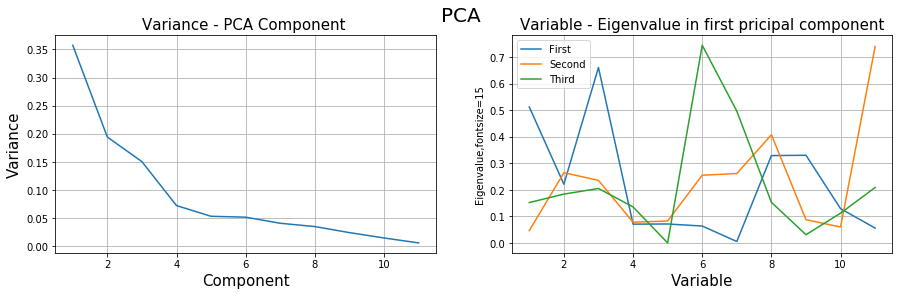

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle('PCA',fontsize=20)


ax1.plot(np.arange(1, pca.explained_variance_ratio_.size + 1), pca.explained_variance_ratio_)
# plt.xticks(np.arange(1, pca.explained_variance_ratio_.size + 1))
ax1.set_xlabel('Component',fontsize=15)
ax1.set_ylabel('Variance',fontsize=15)
ax1.set_title('Variance - PCA Component ',fontsize=15)
ax1.grid()
ax2.plot(np.arange(1, pca.explained_variance_ratio_.size + 1),abs(pca.components_[0]),label='First')
ax2.plot(np.arange(1, pca.explained_variance_ratio_.size + 1),abs(pca.components_[1]),label='Second')
ax2.plot(np.arange(1, pca.explained_variance_ratio_.size + 1),abs(pca.components_[2]),label='Third')
ax2.legend(loc='upper left')

ax2.set_xlabel('Variable',fontsize=15)
ax2.set_ylabel('Eigenvalue,fontsize=15')
ax2.set_title('Variable - Eigenvalue in first pricipal component',fontsize=15)
ax2.grid()


print("explained_variance_ratio_")
print(pca.explained_variance_ratio_)
print("components")
print(abs(pca.components_[1]))
print(abs(pca.components_[2]))

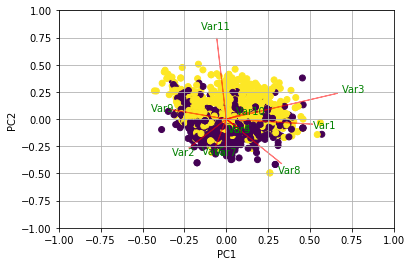

In [83]:
pca = PCA()
x_new = pca.fit_transform(df_wine_x)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = df_wine_y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [274]:
#ICA
kurtosis_values = []
for i in range(1,52,1):
    X_ICA = FastICA(n_components = i,random_state=2).fit_transform(df_mkt_x)
    kur = scipy.stats.kurtosis(X_ICA)
    kurtosis_values.append(np.mean(kur)/i)
kurtosis_values = np.array(kurtosis_values)


D:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  

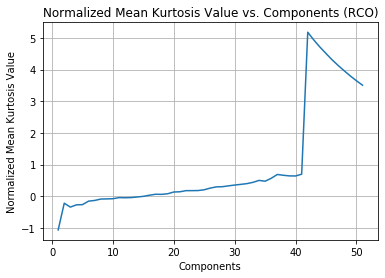

In [97]:
plt.plot(np.arange(1,52,1),kurtosis_values)
plt.xlabel('Components')
plt.ylabel('Normalized Mean Kurtosis Value')
plt.title('Normalized Mean Kurtosis Value vs. Components (RCO)')
plt.grid()
plt.savefig('rice_ica_kurtosis.png')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (11,) and (51,)

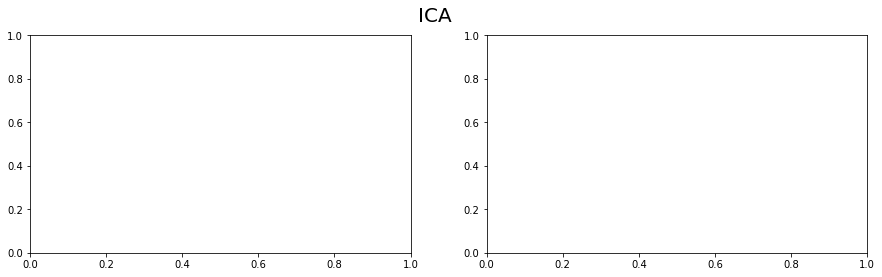

In [275]:
kurtosis_values2 = []
for i in range(1,12,1):
    X_ICA = FastICA(n_components = i,random_state=2).fit_transform(df_wine_x)
    kur = scipy.stats.kurtosis(X_ICA)
    kurtosis_values2.append(np.mean(kur)/i)
kurtosis_values2 = np.array(kurtosis_values2)




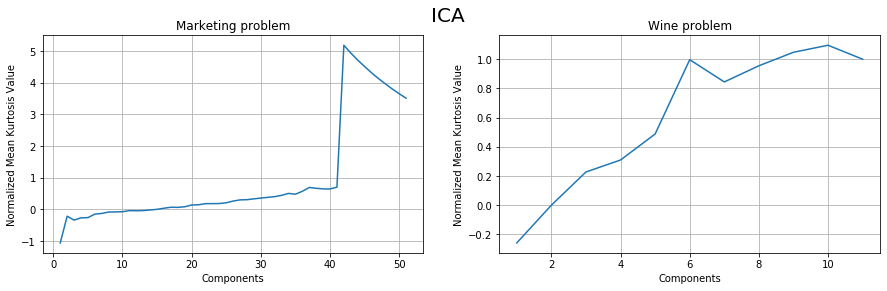

In [276]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle('ICA',fontsize=20)

ax1.plot(np.arange(1,52,1),kurtosis_values)
ax1.set_xlabel('Components')
ax1.set_ylabel('Normalized Mean Kurtosis Value')
ax1.set_title('Marketing problem')
ax1.grid()

ax2.plot(np.arange(1,12,1),kurtosis_values2)
ax2.set_xlabel('Components')
ax2.set_ylabel('Normalized Mean Kurtosis Value')
ax2.set_title('Wine problem')
ax2.grid()


fig.savefig('ica_kurtosis.png')

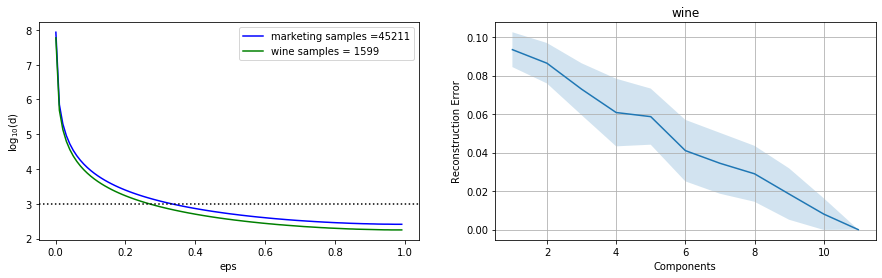

In [325]:
#RP
# https://stackabuse.com/random-projection-theory-and-implementation-in-python-with-scikit-learn/
from sklearn.random_projection import SparseRandomProjection, johnson_lindenstrauss_min_dim
from sklearn.random_projection import GaussianRandomProjection
import numpy as np
from matplotlib import pyplot as plt
import sklearn.datasets as dt
from sklearn.metrics.pairwise import euclidean_distances

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
# fig.suptitle('ICA',fontsize=20)

eps = np.arange(0.001, 0.999, 0.01)
colors = ['b', 'g']
m = [df_mkt.shape[0],df_wine.shape[0]]
for i in range(2):
    min_dim = johnson_lindenstrauss_min_dim(n_samples=m[i], eps=eps)
    if i == 0:
        label='marketing samples ='+ str(m[i])
    else:
        label = 'wine samples = ' + str(m[i])
    ax1.plot(eps, np.log10(min_dim), c=colors[i], label=label)
    
ax1.set_xlabel('eps')
ax1.set_ylabel('log$_{10}$(d)')
ax1.axhline(y=3, color='k', linestyle=':')
ax1.legend()

reconstruction_error2 = []
reconstruction_variance2 = []
for i in range(1,12):
    mean_mse = []
    for j in range(0,100):
        rp = GaussianRandomProjection(n_components=i)
        X_RP = rp.fit(df_wine_x)
        w = X_RP.components_
        p = pinv(w)
        reconstructed = ((p@w)@(df_wine_x.T)).T
        mean_mse.append(mean_squared_error(df_wine_x,reconstructed))
    reconstruction_variance2.append(np.std(mean_mse))
    reconstruction_error2.append(np.mean(mean_mse))

reconstruction_error2 = np.array(reconstruction_error2)

ax2.plot(np.arange(1,12),reconstruction_error2)
ax2.fill_between(np.arange(1,12),reconstruction_error2 - reconstruction_variance2, reconstruction_error2 + reconstruction_variance2, alpha=0.2)
ax2.set_xlabel('Components')
ax2.set_ylabel('Reconstruction Error')
ax2.set_title('wine')
ax2.grid()


In [324]:
reconstruction_error = []
reconstruction_variance = []
for i in range(1,52):
    mean_mse = []
    for j in range(0,100):
        rp = GaussianRandomProjection(n_components=i)
        X_RP = rp.fit(df_mkt_x)
        w = X_RP.components_
        p = pinv(w)
        reconstructed = ((p@w)@(df_mkt_x.T)).T
        mean_mse.append(mean_squared_error(df_mkt_x,reconstructed))
    reconstruction_variance.append(np.std(mean_mse))
    reconstruction_error.append(np.mean(mean_mse))

reconstruction_error = np.array(reconstruction_error)

reconstruction_error2 = []
reconstruction_variance2 = []
for i in range(1,12):
    mean_mse = []
    for j in range(0,100):
        rp = GaussianRandomProjection(n_components=i)
        X_RP = rp.fit(df_wine_x)
        w = X_RP.components_
        p = pinv(w)
        reconstructed = ((p@w)@(df_wine_x.T)).T
        mean_mse.append(mean_squared_error(df_wine_x,reconstructed))
    reconstruction_variance2.append(np.std(mean_mse))
    reconstruction_error2.append(np.mean(mean_mse))

reconstruction_error2 = np.array(reconstruction_error2)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle('Construction Error - Number of Components',fontsize=20)

ax1.plot(np.arange(1,12),reconstruction_error)
ax1.fill_between(np.arange(1,12),reconstruction_error - reconstruction_variance, reconstruction_error + reconstruction_variance, alpha=0.2)
ax1.set_xlabel('Components')
ax1.set_ylabel('Reconstruction Error')
ax1.set_title('marketing')
ax1.grid()

ax2.plot(np.arange(1,12),reconstruction_error)
ax2.fill_between(np.arange(1,12),reconstruction_error - reconstruction_variance, reconstruction_error + reconstruction_variance, alpha=0.2)
ax2.set_xlabel('Components')
ax2.set_ylabel('Reconstruction Error')
ax2.set_title('wine')
ax2.grid()

plt.savefig('rp_error.png')
plt.show()

TypeError: ufunc 'matmul' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

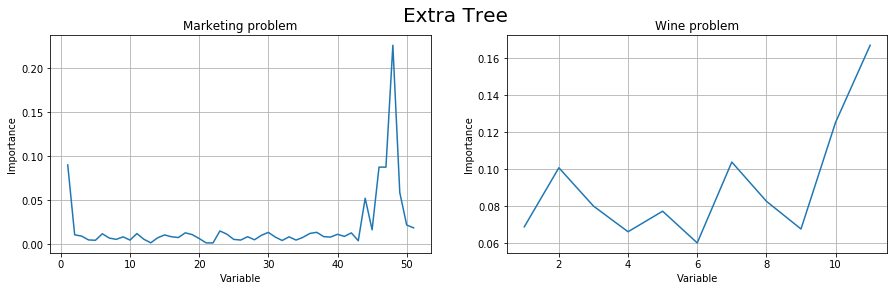

In [136]:
#Extra tree classifier
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(df_mkt_x, df_mkt_y)

model2 = ExtraTreesClassifier(n_estimators=10)
model2.fit(df_wine_x, df_wine_y)
# print(model2.feature_importances_)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle('Extra Tree',fontsize=20)

ax1.plot(np.arange(1,52,1),model.feature_importances_)
ax1.set_xlabel('Variable')
ax1.set_ylabel('Importance')
ax1.set_title('Marketing problem')
ax1.grid()

ax2.plot(np.arange(1,12,1),model2.feature_importances_)
ax2.set_xlabel('Variable')
ax2.set_ylabel('Importance')
ax2.set_title('Wine problem')
ax2.grid()


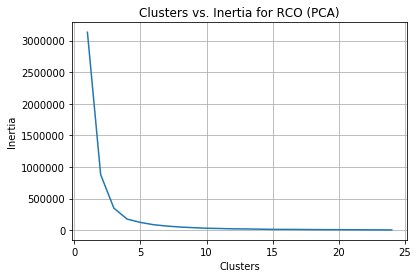

In [138]:
##clustering with dimensionality reduction
X_PCA = PCA(n_components = 1).fit_transform(df_mkt_x)

range_n_clusters = np.arange(1,25,1)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=42)
    k_means_clustering.fit(X_PCA)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)
plt.plot(range_n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters - Inertia')
plt.grid()
plt.savefig('rice_inertia_pca.png')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.6042911788906056 The average homogeneity_score is : 0.0020740692923103096 The average completeness_score is : 0.0010804947630679196 The average v_measure_score is : 0.001420811858146009
For n_clusters = 2 The average silhouette_score is : 0.3339261119073215 The average homogeneity_score is : 0.031325476367050804 The average completeness_score is : 0.031942058255334166 The average v_measure_score is : 0.031630762822182225


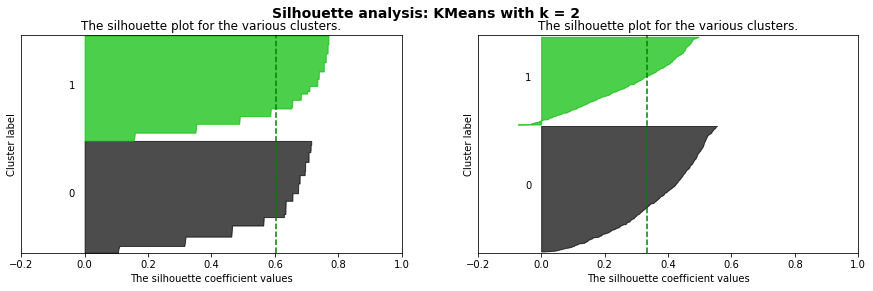

In [291]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

range_n_clusters = np.arange(2, 3, 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle('Kmeans PCA',fontsize=15)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns

    X_PCA = PCA(n_components = 1).fit_transform(df_mkt_x)
    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_PCA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(X_PCA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_PCA, cluster_labels)
    homogeneity_avg = homogeneity_score(df_mkt_y, cluster_labels)
    completeness_avg = completeness_score(df_mkt_y, cluster_labels)
    v_avg = v_measure_score(df_mkt_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_PCA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

# #     WINE
    X_PCA = PCA(n_components = 3).fit_transform(df_wine_x)
    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax2.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax2.set_ylim([0, len(X_PCA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(X_PCA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_PCA, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_PCA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax2.set_title("The silhouette plot for the various clusters.")
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax2.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])
 

    fig.suptitle(
        "Silhouette analysis: KMeans with k = %d"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('mkt_kmeans_silhouette.png')
plt.show()

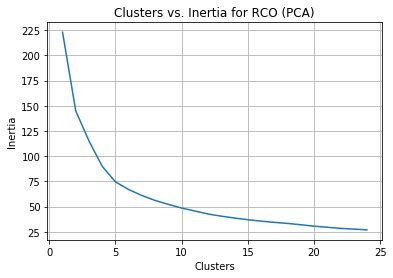

In [149]:
##clustering with dimensionality reduction
X_PCA = PCA(n_components = 3).fit_transform(df_wine_x)

range_n_clusters = np.arange(1,25,1)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=42)
    k_means_clustering.fit(X_PCA)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)
plt.plot(range_n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for RCO (PCA)')
plt.grid()
plt.savefig('rice_inertia_pca.png')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3339261119072865 The average homogeneity_score is : 0.031325476367050804 The average completeness_score is : 0.031942058255334166 The average v_measure_score is : 0.031630762822182225
For n_clusters = 3 The average silhouette_score is : 0.30120755666044424 The average homogeneity_score is : 0.05008203884986532 The average completeness_score is : 0.032391173476032445 The average v_measure_score is : 0.03933922209817902
For n_clusters = 4 The average silhouette_score is : 0.3214927804606027 The average homogeneity_score is : 0.1234589877573617 The average completeness_score is : 0.06321561100716057 The average v_measure_score is : 0.08361646841145307


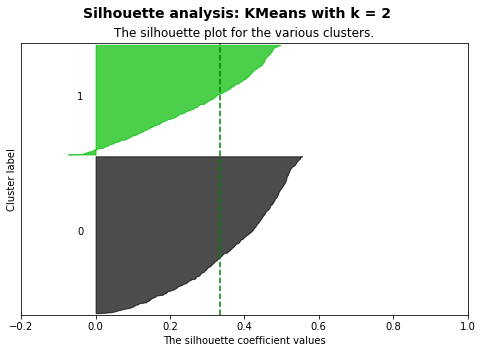

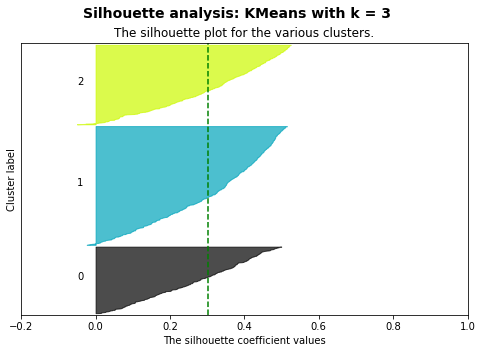

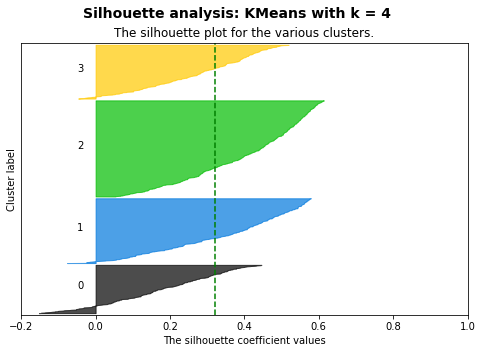

In [152]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

range_n_clusters = np.arange(2, 5, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig,(ax1) = plt.subplots(1, 1)
    fig.set_size_inches(8,5)

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_PCA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(X_PCA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_PCA, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_PCA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

 

    fig.suptitle(
        "Silhouette analysis: KMeans with k = %d"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('mkt_kmeans_silhouette.png')
plt.show()

In [292]:
##clustering with dimensionality reduction
X_ICA = FastICA(n_components = 42).fit_transform(df_mkt_x)

range_n_clusters = np.arange(1,25,1)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=2)
    k_means_clustering.fit(X_ICA)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)
plt.plot(range_n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for RCO (PCA)')
plt.grid()
plt.savefig('mkt_inertia_ica.png')
plt.show()

D:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


KeyboardInterrupt: 

D:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


For n_clusters = 3 The average silhouette_score is : 0.24028721790297725 The average homogeneity_score is : 0.07764778541922002 The average completeness_score is : 0.11876868357639653 The average v_measure_score is : 0.09390378825177934
For n_clusters = 3 The average silhouette_score is : 0.11129024477925854 The average homogeneity_score is : 0.08873257201923015 The average completeness_score is : 0.06012562485106237 The average v_measure_score is : 0.07168031656257186


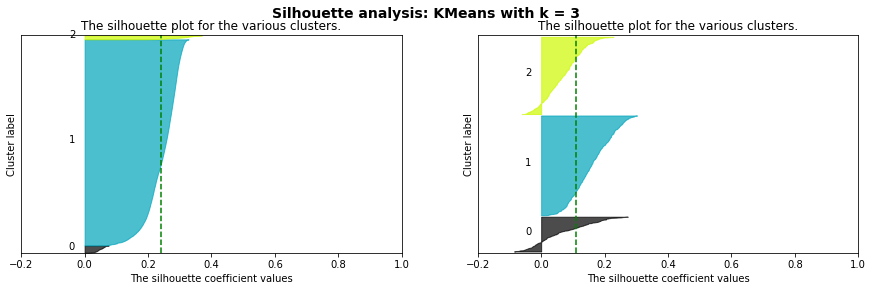

In [294]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

range_n_clusters = np.arange(3, 4, 1)
fig,(ax1,ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle('Kmeans ICA',fontsize=15)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns

    X_ICA = FastICA(n_components = 42).fit_transform(df_mkt_x)
    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_ICA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(X_ICA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_ICA, cluster_labels)
    homogeneity_avg = homogeneity_score(df_mkt_y, cluster_labels)
    completeness_avg = completeness_score(df_mkt_y, cluster_labels)
    v_avg = v_measure_score(df_mkt_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_ICA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])
    
#     Wine
    X_ICA = FastICA(n_components = 10).fit_transform(df_wine_x)
    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax2.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax2.set_ylim([0, len(X_ICA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(X_ICA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_ICA, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_ICA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax2.set_title("The silhouette plot for the various clusters.")
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax2.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

 

    fig.suptitle(
        "Silhouette analysis: KMeans with k = %d"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('mkt_kmeans_silhouette.png')
plt.show()

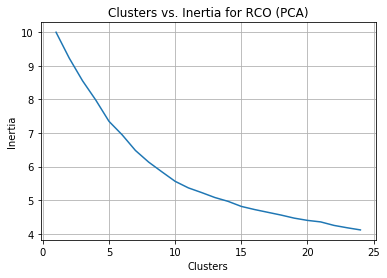

In [156]:
##clustering with dimensionality reduction
X_ICA = FastICA(n_components = 10).fit_transform(df_wine_x)

range_n_clusters = np.arange(1,25,1)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=2)
    k_means_clustering.fit(X_ICA)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)
plt.plot(range_n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for RCO (PCA)')
plt.grid()
plt.savefig('mkt_inertia_ica.png')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.09855394424374143 The average homogeneity_score is : 0.05950286843466294 The average completeness_score is : 0.06057584000002102 The average v_measure_score is : 0.06003456041169951
For n_clusters = 3 The average silhouette_score is : 0.11129024477930624 The average homogeneity_score is : 0.08873257201923015 The average completeness_score is : 0.06012562485106237 The average v_measure_score is : 0.07168031656257186
For n_clusters = 4 The average silhouette_score is : 0.10522697517268302 The average homogeneity_score is : 0.11804475795205262 The average completeness_score is : 0.07562993751660123 The average v_measure_score is : 0.09219291809363916


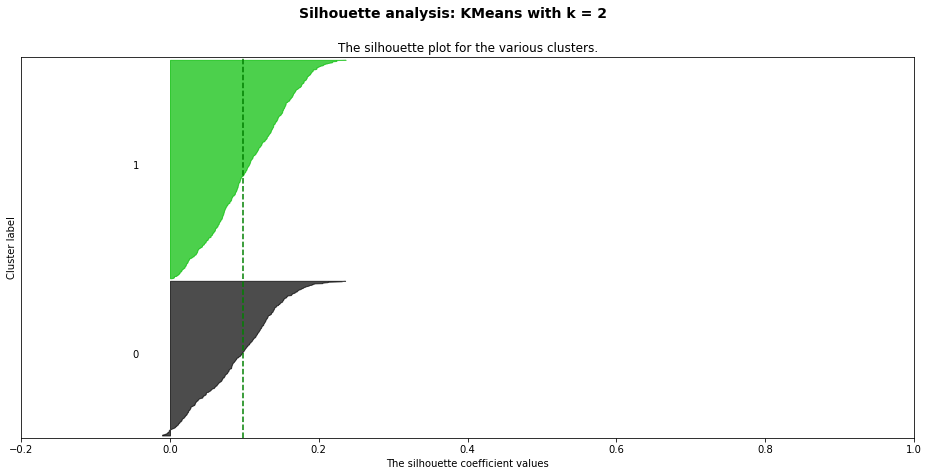

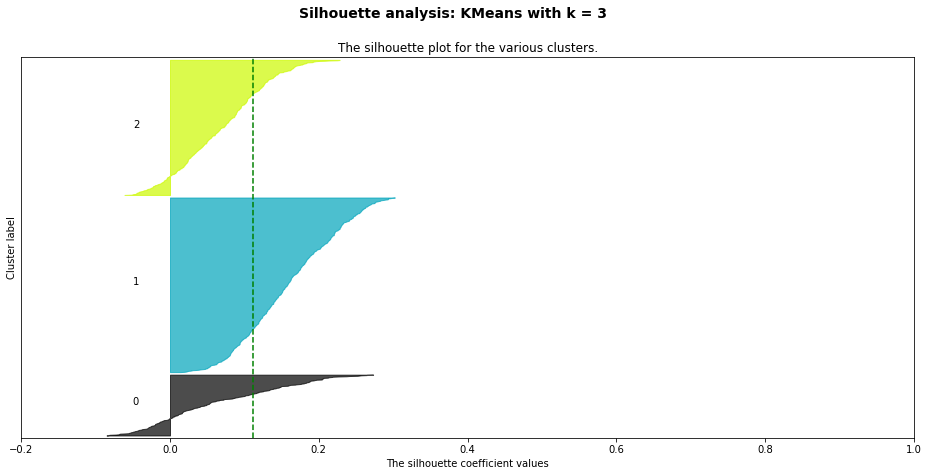

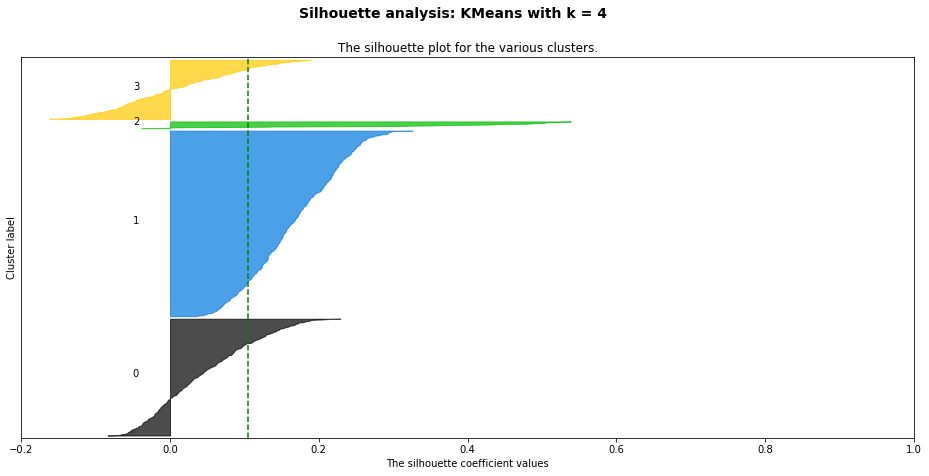

In [157]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

range_n_clusters = np.arange(2, 5, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig,(ax1) = plt.subplots(1, 1)
    fig.set_size_inches(16, 7)

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_ICA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(X_ICA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_ICA, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_ICA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

 

    fig.suptitle(
        "Silhouette analysis: KMeans with k = %d"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('mkt_kmeans_silhouette.png')
plt.show()

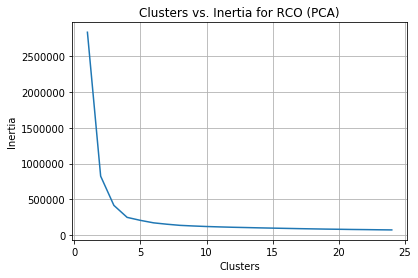

In [158]:
##RP
X_RP = GaussianRandomProjection(n_components = 3).fit_transform(df_mkt_x)

range_n_clusters = np.arange(1,25,1)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=2)
    k_means_clustering.fit(X_RP)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)
plt.plot(range_n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for RCO (PCA)')
plt.grid()
plt.savefig('mkt_inertia_ica.png')
plt.show()


For n_clusters = 2 The average silhouette_score is : 0.5270983994783385 The average homogeneity_score is : 0.0015984075072853004 The average completeness_score is : 0.0008322005534862215 The average v_measure_score is : 0.001094537316589931
For n_clusters = 2 The average silhouette_score is : 0.35621510802159534 The average homogeneity_score is : 0.00044873480344930226 The average completeness_score is : 0.00045787191429336443 The average v_measure_score is : 0.0004532573153152121


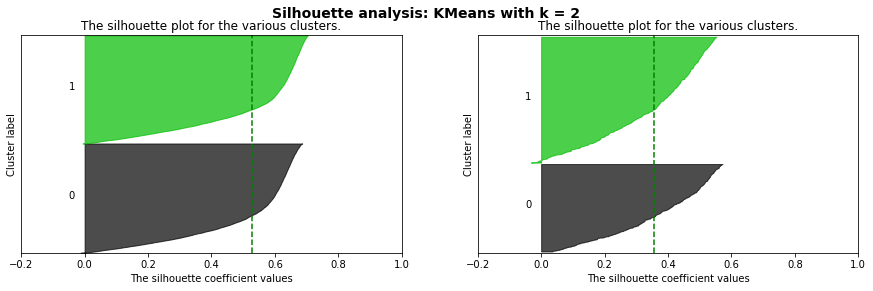

In [295]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

range_n_clusters = np.arange(2, 3, 1)
fig,(ax1,ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle('Kmeans RP',fontsize=15)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    X_RP = GaussianRandomProjection(n_components = 3).fit_transform(df_mkt_x)

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_RP) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(X_RP)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_RP, cluster_labels)
    homogeneity_avg = homogeneity_score(df_mkt_y, cluster_labels)
    completeness_avg = completeness_score(df_mkt_y, cluster_labels)
    v_avg = v_measure_score(df_mkt_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_RP, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

#     WINE
    X_RP = GaussianRandomProjection(n_components = 3).fit_transform(df_wine_x)
    ax2.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax2.set_ylim([0, len(X_RP) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(X_RP)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_RP, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_RP, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax2.set_title("The silhouette plot for the various clusters.")
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax2.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

 

    fig.suptitle(
        "Silhouette analysis: KMeans with k = %d"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('mkt_kmeans_silhouette.png')
plt.show()

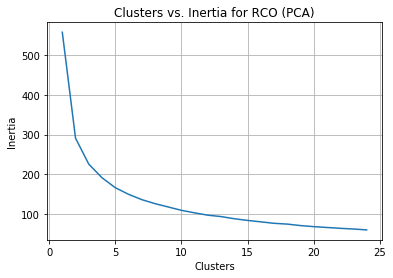

In [165]:
##RP
X_RP = GaussianRandomProjection(n_components = 3).fit_transform(df_wine_x)

range_n_clusters = np.arange(1,25,1)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=2)
    k_means_clustering.fit(X_RP)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)
plt.plot(range_n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for RCO (PCA)')
plt.grid()
plt.savefig('mkt_inertia_ica.png')
plt.show()


For n_clusters = 2 The average silhouette_score is : 0.40087410011963776 The average homogeneity_score is : 0.003488996497436056 The average completeness_score is : 0.0034807572560861303 The average v_measure_score is : 0.0034848720067828685
For n_clusters = 3 The average silhouette_score is : 0.30299309309558276 The average homogeneity_score is : 0.006172690828204385 The average completeness_score is : 0.00397489676465175 The average v_measure_score is : 0.004835791478064848


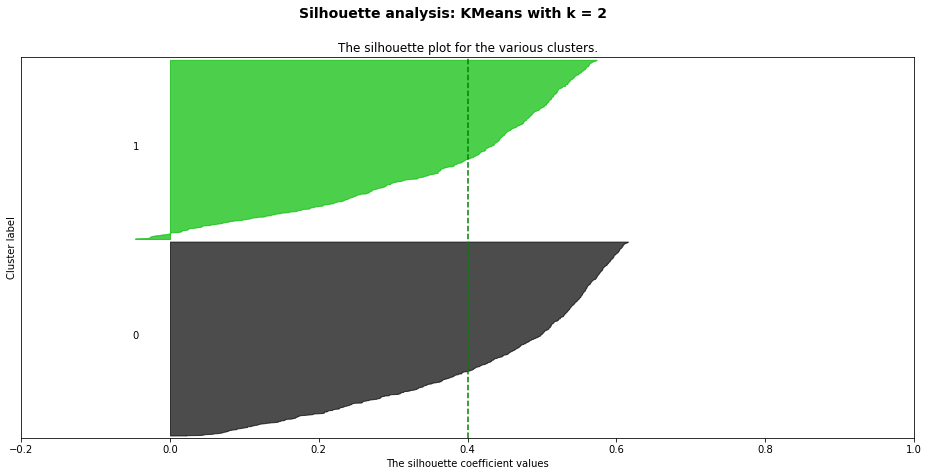

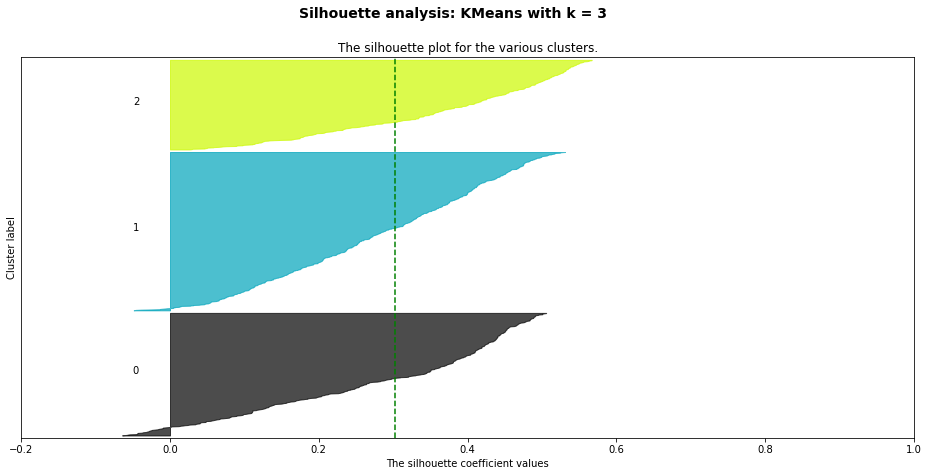

In [166]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

range_n_clusters = np.arange(2, 4, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig,(ax1) = plt.subplots(1, 1)
    fig.set_size_inches(16, 7)

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_RP) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(X_RP)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_RP, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_RP, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

 

    fig.suptitle(
        "Silhouette analysis: KMeans with k = %d"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('mkt_kmeans_silhouette.png')
plt.show()

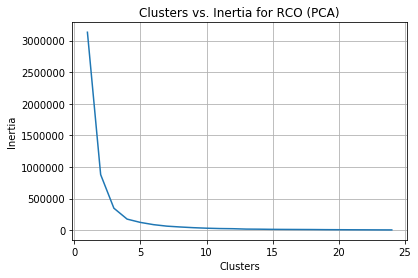

In [167]:
#Tree

df_mkt_x_tree = df_mkt_x[:,[0,45,46,47]]
df_wine_x_tree=df_wine_x[:,[1,6,9,10]]


range_n_clusters = np.arange(1,25,1)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=2)
    k_means_clustering.fit(df_mkt_x_tree)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)
plt.plot(range_n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for RCO (PCA)')
plt.grid()
plt.savefig('mkt_inertia_ica.png')
plt.show()


For n_clusters = 2 The average silhouette_score is : 0.6028729955001176 The average homogeneity_score is : 0.0020740692923103096 The average completeness_score is : 0.0010804947630679196 The average v_measure_score is : 0.001420811858146009
For n_clusters = 2 The average silhouette_score is : 0.30647948189299073 The average homogeneity_score is : 0.1507759841516496 The average completeness_score is : 0.15724543706038804 The average v_measure_score is : 0.15394277081667934


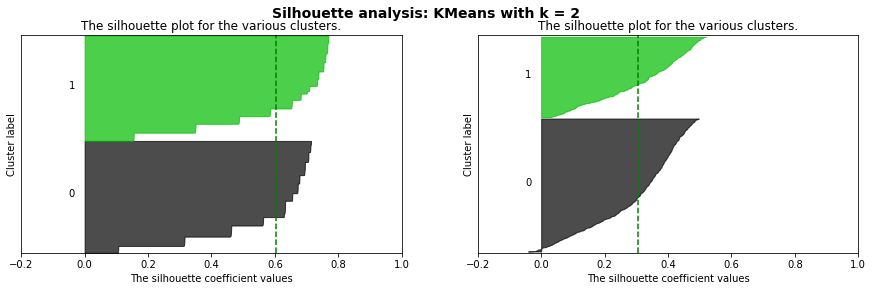

In [297]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

range_n_clusters = np.arange(2, 3, 1)
fig,(ax1,ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle('Kmeans Tree',fontsize=15)
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns


    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_mkt_x_tree) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(df_mkt_x_tree)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_mkt_x_tree, cluster_labels)
    homogeneity_avg = homogeneity_score(df_mkt_y, cluster_labels)
    completeness_avg = completeness_score(df_mkt_y, cluster_labels)
    v_avg = v_measure_score(df_mkt_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_mkt_x_tree, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

#     WINE
    ax2.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax2.set_ylim([0, len(df_wine_x_tree) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(df_wine_x_tree)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_wine_x_tree, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_wine_x_tree, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax2.set_title("The silhouette plot for the various clusters.")
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax2.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

 

    fig.suptitle(
        "Silhouette analysis: KMeans with k = %d"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('kmeans_tree_silhouette.png')
plt.show()

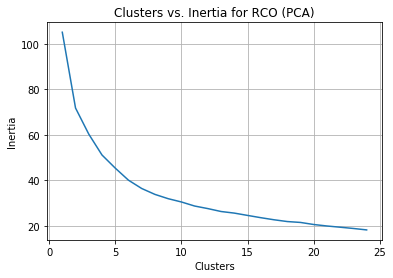

In [170]:
#Tree

range_n_clusters = np.arange(1,25,1)
inertia = []
for n_clusters in range_n_clusters:
    k_means_clustering = KMeans(n_clusters=n_clusters, random_state=2)
    k_means_clustering.fit(df_wine_x_tree)
    inertia.append(k_means_clustering.inertia_)
inertia = np.array(inertia)
plt.plot(range_n_clusters,inertia)
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Clusters vs. Inertia for RCO (PCA)')
plt.grid()
plt.savefig('mkt_inertia_ica.png')
plt.show()


For n_clusters = 2 The average silhouette_score is : 0.30647948189299073 The average homogeneity_score is : 0.1507759841516496 The average completeness_score is : 0.15724543706038804 The average v_measure_score is : 0.15394277081667934
For n_clusters = 3 The average silhouette_score is : 0.2654623479417422 The average homogeneity_score is : 0.1657715013254841 The average completeness_score is : 0.11070462527294478 The average v_measure_score is : 0.13275411632069264


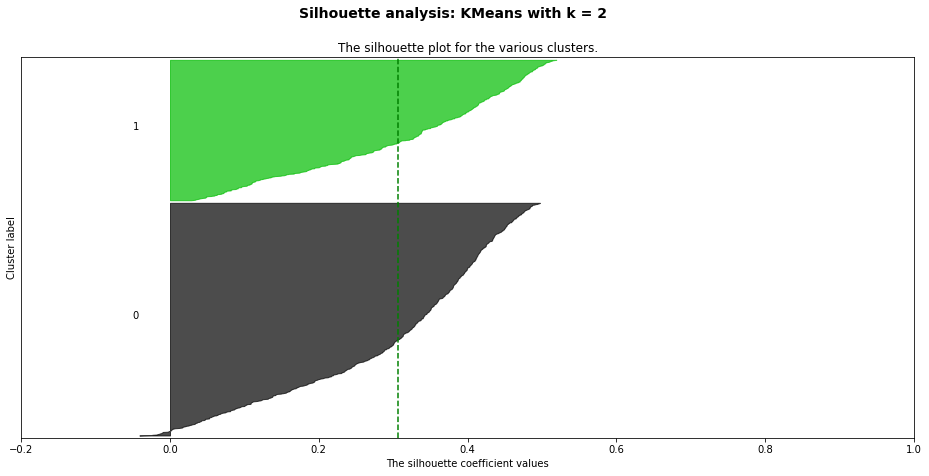

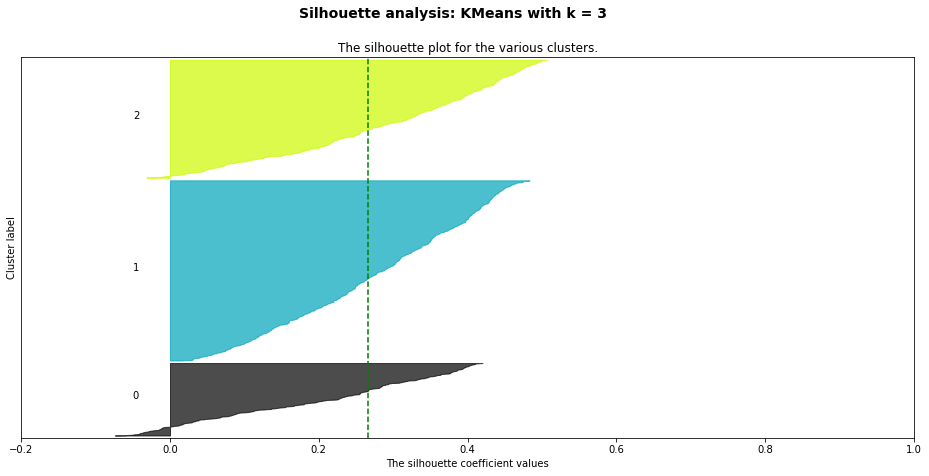

In [171]:
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

range_n_clusters = np.arange(2, 4, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig,(ax1) = plt.subplots(1, 1)
    fig.set_size_inches(16, 7)

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_wine_x_tree) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=2)
    cluster_labels = clusterer.fit_predict(df_wine_x_tree)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_wine_x_tree, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_wine_x_tree, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

 

    fig.suptitle(
        "Silhouette analysis: KMeans with k = %d"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('mkt_kmeans_silhouette.png')
plt.show()

###step 4: EM GMM###

For n_clusters = 2 The average silhouette_score is : 0.60235521869884 The average homogeneity_score is : 0.0015503715978649915 The average completeness_score is : 0.0008136101990920017 The average v_measure_score is : 0.0010671809284058277
For n_clusters = 3 The average silhouette_score is : 0.2720876806544465 The average homogeneity_score is : 0.07495474877119941 The average completeness_score is : 0.049274152997137104 The average v_measure_score is : 0.059460104794316244


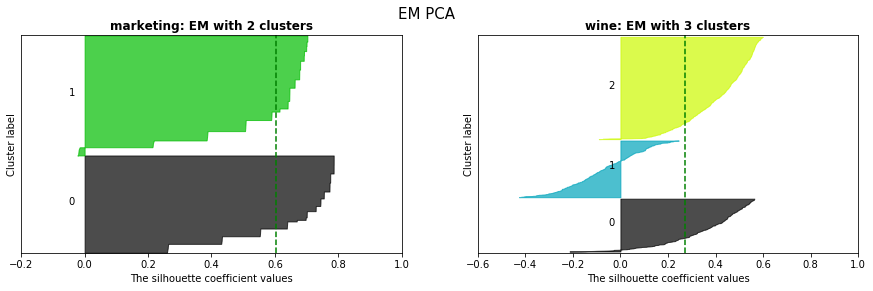

In [311]:
###EM GMM
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/
X_PCA = PCA(n_components = 1).fit_transform(df_mkt_x)

range_n_clusters=[2]
fig,(ax1,ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle('EM PCA',fontsize=15)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_PCA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(X_PCA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_PCA, cluster_labels)
    homogeneity_avg = homogeneity_score(df_mkt_y, cluster_labels)
    completeness_avg = completeness_score(df_mkt_y, cluster_labels)
    v_avg = v_measure_score(df_mkt_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_PCA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])
    
#     WINE
    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    n_clusters=3
    X_PCA = PCA(n_components = 3).fit_transform(df_wine_x)
    ax2.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax2.set_ylim([0, len(X_PCA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(X_PCA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_PCA, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_PCA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax2.set_title("The silhouette plot for the various clusters.")
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax2.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.6,-0.4,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

    ax1.set_title(
        "marketing: EM with 2 clusters",
        fontsize=12,fontweight="bold")
    ax2.set_title(
        "wine: EM with 3 clusters",
        fontsize=12,fontweight="bold")
fig.savefig('em_pca_silhouette.png')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.251487264410992 The average homogeneity_score is : 0.07076493221102256 The average completeness_score is : 0.0707224220329272 The average v_measure_score is : 0.07074367073583794
For n_clusters = 3 The average silhouette_score is : 0.2750984197149499 The average homogeneity_score is : 0.048550466589345476 The average completeness_score is : 0.031072697706283594 The average v_measure_score is : 0.03789334385728672
For n_clusters = 4 The average silhouette_score is : 0.2701321403788299 The average homogeneity_score is : 0.1207611540319776 The average completeness_score is : 0.06195808214192697 The average v_measure_score is : 0.08189755668577756


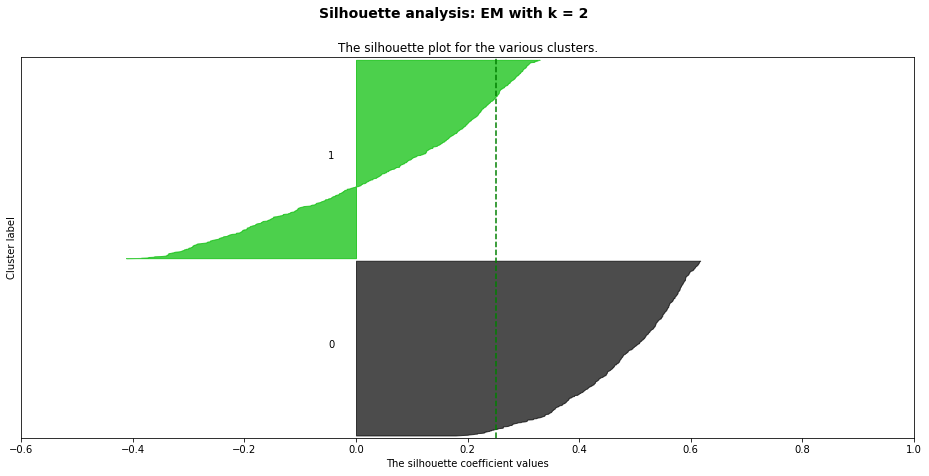

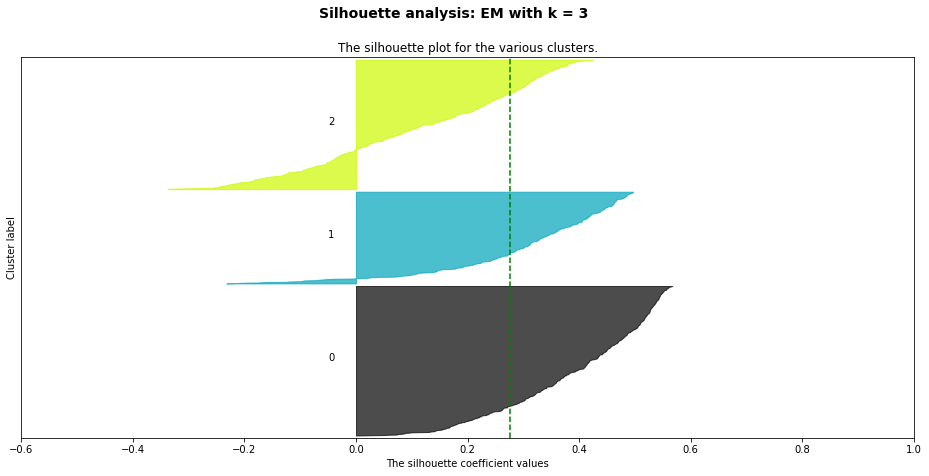

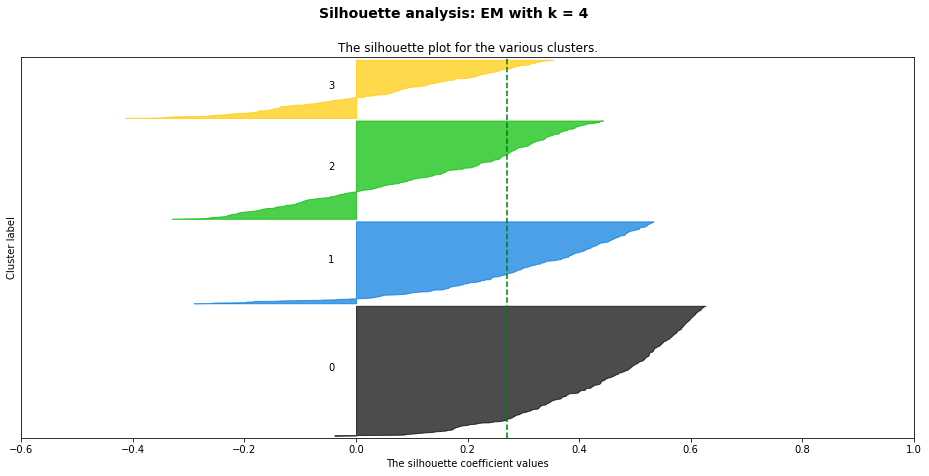

In [302]:
XXXXX
###EM GMM
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/
X_PCA = PCA(n_components = 3).fit_transform(df_wine_x)

range_n_clusters = np.arange(2, 5, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(16, 7)

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_PCA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(X_PCA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_PCA, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_PCA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.6,-0.4,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

    ax1.set_title(
        "marketing: EM with k = %d"
        % n_clusters,
        fontsize=14,fontweight="bold")
    ax2.set_title(
        "wine: EM with k = %d"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('mkt_em_silhouette.png')
plt.show()

D:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


For n_clusters = 2 The average silhouette_score is : 0.037774660467082596 The average homogeneity_score is : 0.010600324353537603 The average completeness_score is : 0.005641184701185879 The average v_measure_score is : 0.007363649199012499
For n_clusters = 2 The average silhouette_score is : 0.07262857359065296 The average homogeneity_score is : 0.015842430903562146 The average completeness_score is : 0.015886969797189628 The average v_measure_score is : 0.015864669090519073


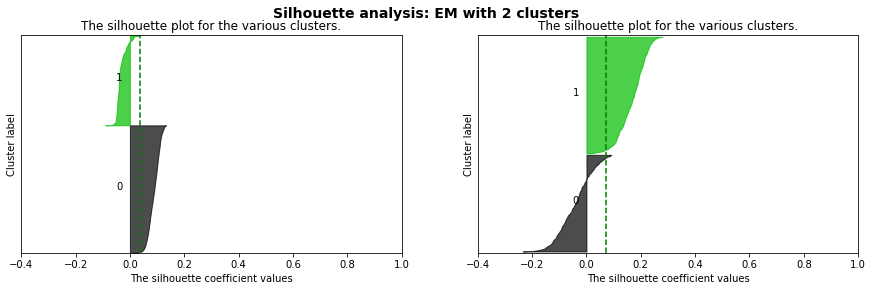

In [309]:
###EM GMM
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/
X_ICA = FastICA(n_components = 42).fit_transform(df_mkt_x)

range_n_clusters = np.arange(2, 3, 1)
fig,(ax1,ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle('EM ICA',fontsize=15)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_ICA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(X_ICA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_ICA, cluster_labels)
    homogeneity_avg = homogeneity_score(df_mkt_y, cluster_labels)
    completeness_avg = completeness_score(df_mkt_y, cluster_labels)
    v_avg = v_measure_score(df_mkt_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_ICA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.4,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])
    
#     WINE
    X_ICA = FastICA(n_components = 10).fit_transform(df_wine_x)
        # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax2.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax2.set_ylim([0, len(X_ICA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(X_ICA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_ICA, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_ICA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax2.set_title("The silhouette plot for the various clusters.")
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax2.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.4,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

    fig.suptitle(
        "Silhouette analysis: EM with 2 clusters",
#         % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('mkt_em_silhouette.png')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.1927272572265324 The average homogeneity_score is : 0.022843211847709745 The average completeness_score is : 0.04107331886274651 The average v_measure_score is : 0.029358493448918103
For n_clusters = 3 The average silhouette_score is : 0.046809099472815315 The average homogeneity_score is : 0.07865670611262258 The average completeness_score is : 0.05416020539350872 The average v_measure_score is : 0.06414941155200453
For n_clusters = 4 The average silhouette_score is : 0.13342003730917842 The average homogeneity_score is : 0.04710385649729932 The average completeness_score is : 0.031746375587195716 The average v_measure_score is : 0.03792954517537004


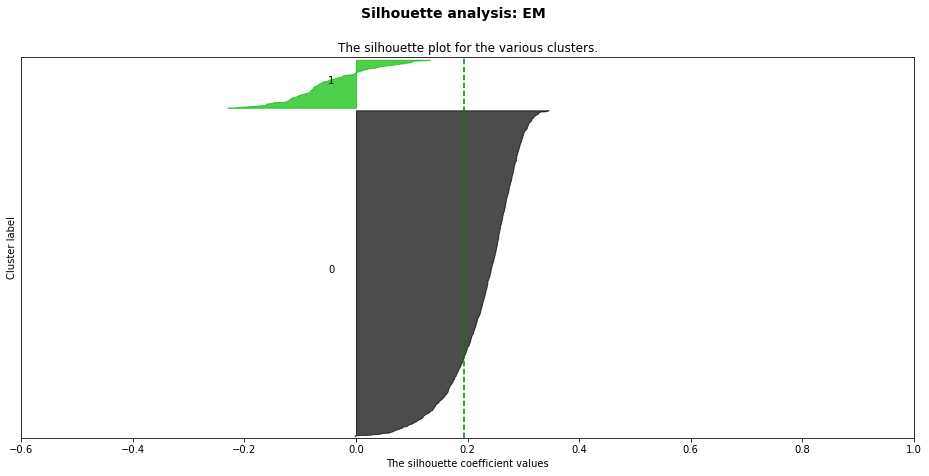

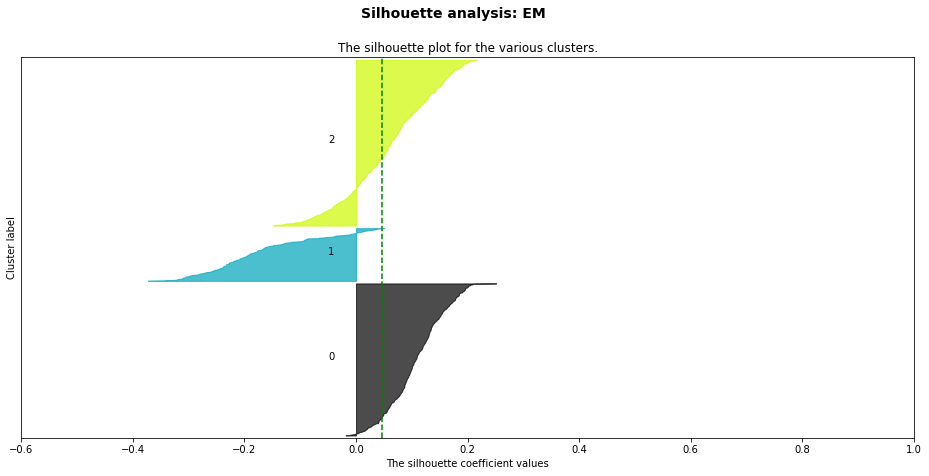

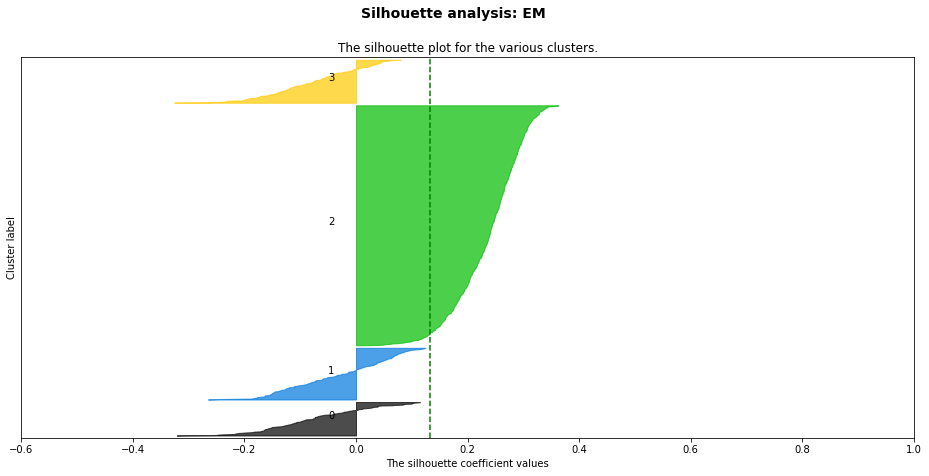

In [181]:
###EM GMM
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/
X_ICA = FastICA(n_components = 10).fit_transform(df_wine_x)

range_n_clusters = np.arange(2, 5, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(16, 7)

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_ICA) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(X_ICA)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_ICA, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_ICA, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.6,-0.4,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

    fig.suptitle(
        "Silhouette analysis: EM"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('mkt_em_silhouette.png')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.4269701322212374 The average homogeneity_score is : 0.00031940961351033074 The average completeness_score is : 0.0001665884045626897 The average v_measure_score is : 0.00021897183090436646
For n_clusters = 2 The average silhouette_score is : 0.2375520725997229 The average homogeneity_score is : 0.005693675012803989 The average completeness_score is : 0.006908558270791485 The average v_measure_score is : 0.006242557920604266


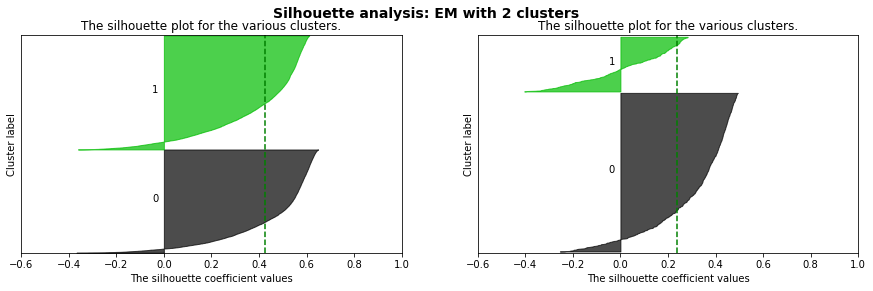

In [310]:
###EM GMM
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/
X_RP = GaussianRandomProjection(n_components = 3).fit_transform(df_mkt_x)

range_n_clusters = np.arange(2, 3, 1)
fig,(ax1,ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle('EM RP',fontsize=15)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_RP) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(X_RP)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_RP, cluster_labels)
    homogeneity_avg = homogeneity_score(df_mkt_y, cluster_labels)
    completeness_avg = completeness_score(df_mkt_y, cluster_labels)
    v_avg = v_measure_score(df_mkt_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_RP, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.6,-0.4,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])
    
#     WINE
    X_RP = GaussianRandomProjection(n_components = 3).fit_transform(df_wine_x)
    ax2.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax2.set_ylim([0, len(X_RP) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(X_RP)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_RP, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_RP, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax2.set_title("The silhouette plot for the various clusters.")
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax2.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.6,-0.4,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

    fig.suptitle(
        "Silhouette analysis: EM with 2 clusters",
        fontsize=14,fontweight="bold")
plt.savefig('mkt_em_silhouette.png')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3591725705942327 The average homogeneity_score is : 0.00012150041849921511 The average completeness_score is : 0.00014865579943479522 The average v_measure_score is : 0.00013371331581251892
For n_clusters = 3 The average silhouette_score is : 0.3034959436742315 The average homogeneity_score is : 0.002032314486003487 The average completeness_score is : 0.001421237128557047 The average v_measure_score is : 0.0016727132684131246
For n_clusters = 4 The average silhouette_score is : 0.2304105154979724 The average homogeneity_score is : 0.0072263259017279705 The average completeness_score is : 0.003753399496617738 The average v_measure_score is : 0.004940613178910302


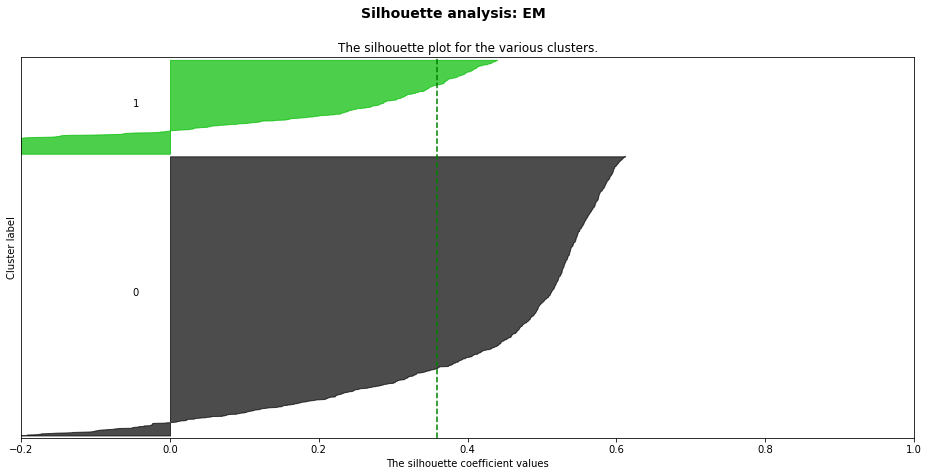

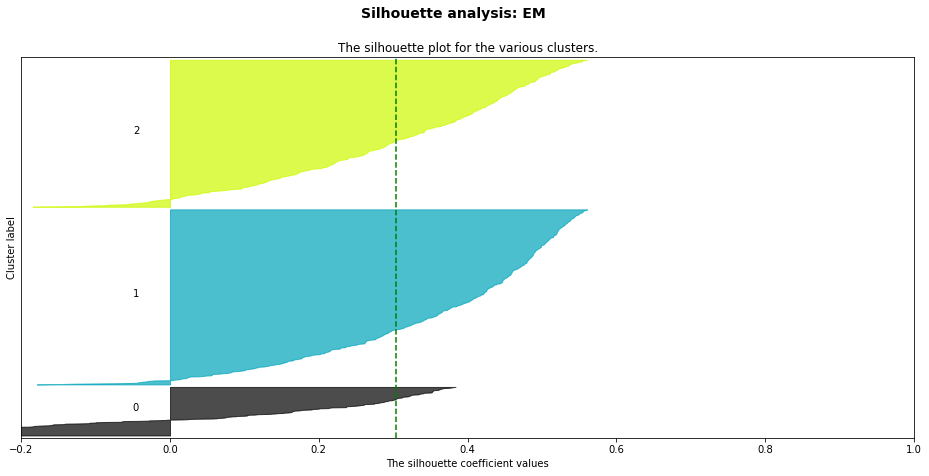

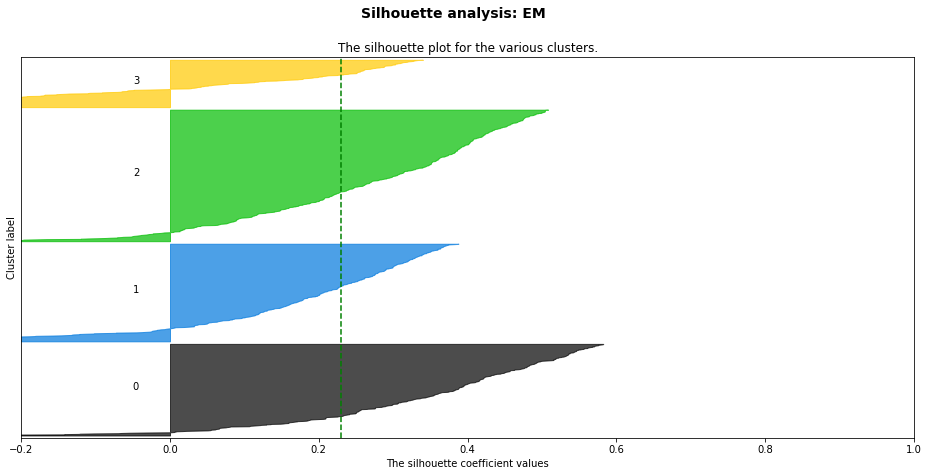

In [184]:
###EM GMM
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

X_RP = GaussianRandomProjection(n_components = 3).fit_transform(df_wine_x)

range_n_clusters = np.arange(2, 5, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(16, 7)

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_RP) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(X_RP)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_RP, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_RP, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

    fig.suptitle(
        "Silhouette analysis: EM"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('mkt_em_silhouette.png')
plt.show()

For n_clusters = 3 The average silhouette_score is : 0.17231356155774846 The average homogeneity_score is : 0.07934436652100808 The average completeness_score is : 0.027686108646847656 The average v_measure_score is : 0.04104880873547076
For n_clusters = 2 The average silhouette_score is : 0.21475718167060467 The average homogeneity_score is : 0.059810520806678126 The average completeness_score is : 0.07353480011599042 The average v_measure_score is : 0.06596638955037652


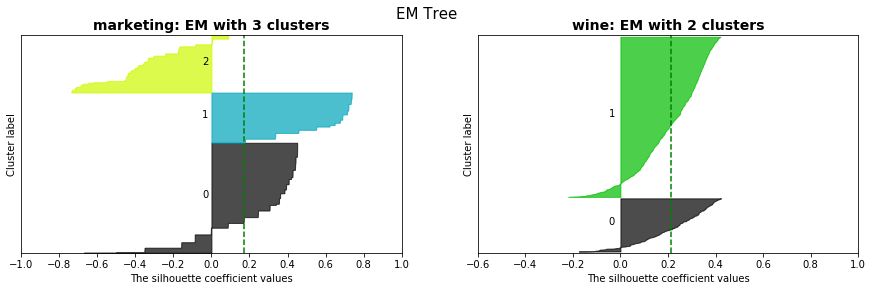

In [313]:
###EM GMM
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/
# X_RP = GaussianRandomProjection(n_components = 3).fit_transform(df_mkt_x)

range_n_clusters = np.arange(3, 4, 1)
fig,(ax1,ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)
fig.suptitle('EM Tree',fontsize=15)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_mkt_x_tree) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(df_mkt_x_tree)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_mkt_x_tree, cluster_labels)
    homogeneity_avg = homogeneity_score(df_mkt_y, cluster_labels)
    completeness_avg = completeness_score(df_mkt_y, cluster_labels)
    v_avg = v_measure_score(df_mkt_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_mkt_x_tree, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1,-0.8,-0.6,-0.4,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])
    
#     WINE
    n_clusters=2
    ax2.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax2.set_ylim([0, len(df_wine_x_tree) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(df_wine_x_tree)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_wine_x_tree, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_wine_x_tree, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax2.set_title("The silhouette plot for the various clusters.")
    ax2.set_xlabel("The silhouette coefficient values")
    ax2.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax2.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.6,-0.4,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

    ax1.set_title(
        "marketing: EM with 3 clusters",
        fontsize=14,fontweight="bold")
    
    ax2.set_title(
        "wine: EM with 2 clusters",
        fontsize=14,fontweight="bold")
plt.savefig('mkt_em_silhouette.png')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.21475718167060467 The average homogeneity_score is : 0.059810520806678126 The average completeness_score is : 0.07353480011599042 The average v_measure_score is : 0.06596638955037652
For n_clusters = 3 The average silhouette_score is : 0.20110865581696183 The average homogeneity_score is : 0.1411372772619094 The average completeness_score is : 0.11495358005978581 The average v_measure_score is : 0.12670686857646457
For n_clusters = 4 The average silhouette_score is : 0.1780231549673721 The average homogeneity_score is : 0.1753574265115231 The average completeness_score is : 0.09930799085708951 The average v_measure_score is : 0.12680441444405233


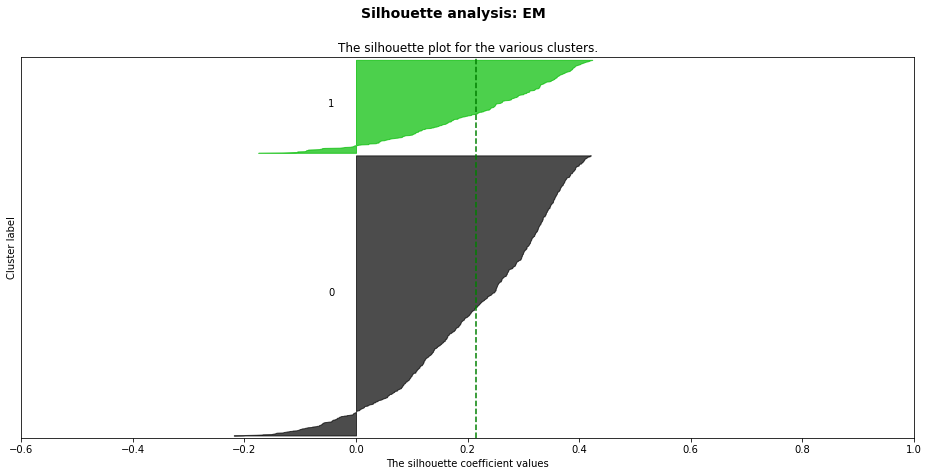

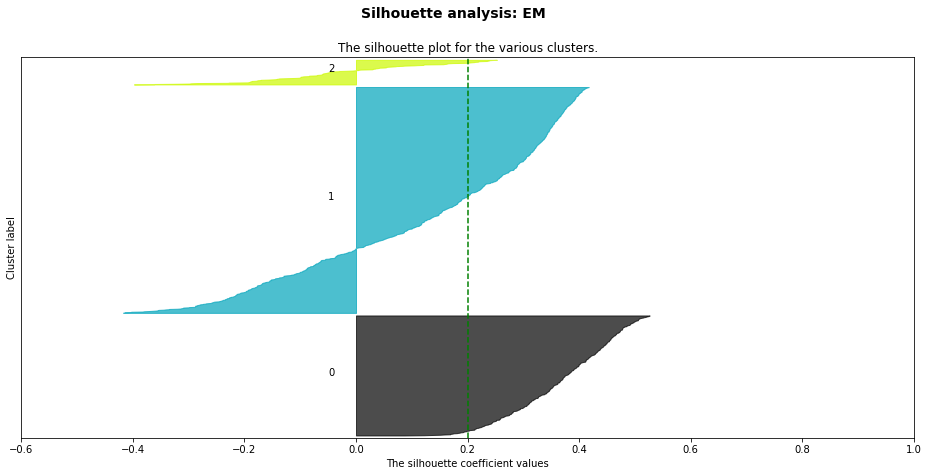

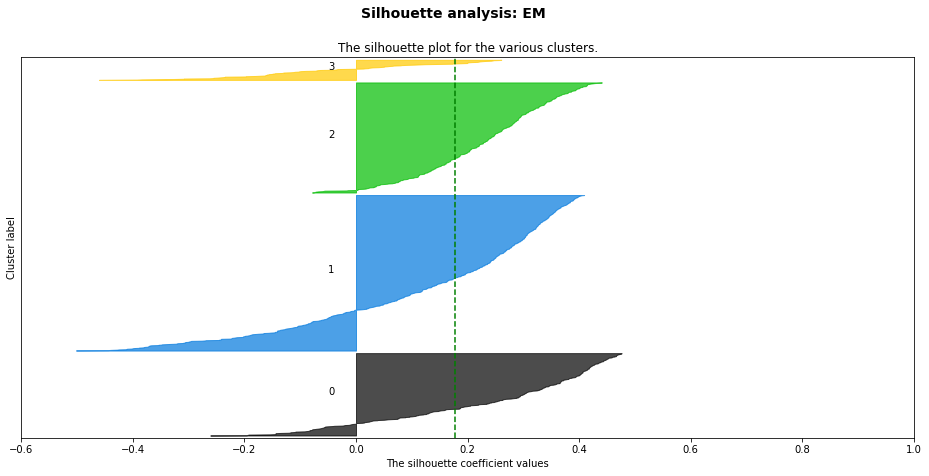

In [187]:
###EM GMM
# Code taken from scikit-learn examples (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
#https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/
# X_RP = GaussianRandomProjection(n_components = 3).fit_transform(df_mkt_x)

range_n_clusters = np.arange(2, 5, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(16, 7)

    # The 1st subplot is the silhouette plot, silhouette coefficient ranges from 0 to 1 
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_wine_x_tree) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
    cluster_labels = clusterer.fit_predict(df_wine_x_tree)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_wine_x_tree, cluster_labels)
    homogeneity_avg = homogeneity_score(df_wine_y, cluster_labels)
    completeness_avg = completeness_score(df_wine_y, cluster_labels)
    v_avg = v_measure_score(df_wine_y, cluster_labels)


    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
        "The average homogeneity_score is :",
        homogeneity_avg,
        "The average completeness_score is :",
        completeness_avg,
        "The average v_measure_score is :",
        v_avg
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_wine_x_tree, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="green", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.6,-0.4,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

    fig.suptitle(
        "Silhouette analysis: EM"
        % n_clusters,
        fontsize=14,fontweight="bold")
plt.savefig('mkt_em_silhouette.png')
plt.show()

In [278]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import cross_validate
import timeit
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#working directory is the one with dataset
os.chdir(r'C:/Users/xpj/Desktop/OMSCS/CS7641/HW/HW3')

X_PCA = PCA(n_components = 3).fit_transform(df_wine_x)
X_ICA = FastICA(n_components = 10).fit_transform(df_wine_x)
X_RP = GaussianRandomProjection(n_components = 3).fit_transform(df_wine_x)
x_all  = [df_wine_x,X_PCA,X_ICA,X_RP,df_wine_x_tree]
x_index = ['None','PCA','ICA','RP','Tree']

# https://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.neural_network import MLPClassifier

def all_tuples(beg, end, sep):
    value = np.arange(beg, end, sep)
    result = []
    for i in value:
        result.append((i,))
    return result



train_pct_sizes = np.linspace(.1, 0.9, 9)

#time
df_training_nn = pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_pred_nn = pd.DataFrame(columns=train_pct_sizes, index=x_index)
# print(df_training_bdtree)
#test_metrics
df_accuracy_nn = pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_precision_nn= pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_recall_nn= pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_f1_nn = pd.DataFrame(columns=train_pct_sizes, index=x_index)
#train_metrics
df_accuracy_train_nn = pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_precision_train_nn= pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_recall_train_nn= pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_f1_train_nn = pd.DataFrame(columns=train_pct_sizes, index=x_index)

def cross_valid(clf, X_train, y_train):
    scoring = ["accuracy", "f1", "precision", "recall"]
    scores = cross_validate(clf, X_train, y_train, scoring=scoring, n_jobs=-1, cv=5, return_train_score=True)
    return scores

def train_test2(size,x):  
    _,y = load_xy2()
    x=x
    X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = size, random_state = 12345)
    return X_train, X_test, y_train, y_test

def classifier_time_metrics(clf, X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    #for train data
    y_pred_train = clf.predict(X_train)
    f1_train = f1_score(y_train,y_pred_train)
    accuracy_train = accuracy_score(y_train,y_pred_train)
    #The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
    precision_train = precision_score(y_train,y_pred_train) 
    recall_train = recall_score(y_train,y_pred_train)
    
    #for test data
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    #The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
    precision = precision_score(y_test,y_pred) 
    recall = recall_score(y_test,y_pred)

    
    return training_time, pred_time, accuracy,f1,precision, recall,accuracy_train, f1_train, precision_train, recall_train

def interpret_cross_valid_scores(scores):
#     train_metrics = ["train_accuracy", "train_f1", "train_precision", "train_recall"]
#     test_metrics = ["test_accuracy", "test_f1", "test_precision", "test_recall"]
    #test metrics
    accuracy = scores.get('test_accuracy')
    f1 = scores.get('test_f1')
    precision = scores.get('test_precision')
    recall = scores.get('test_recall')
    #train metrics
    accuracy_train = scores.get('train_accuracy')
    f1_train = scores.get('train_f1')
    precision_train = scores.get('train_precision')
    recall_train = scores.get('train_recall')
    return accuracy,f1,precision, recall
# accuracy_train, f1_train, precision_train, recall_train
    

count_k = 0
layer = (10,)

for x in x_all:
    clf = MLPClassifier(solver='sgd', activation = 'tanh', hidden_layer_sizes=layer, random_state=1)
    count_i = 0
    for i in train_pct_sizes:
        X_train, X_test, y_train, y_test = train_test2(i,x)
        
        clf = clf.fit(X_train,y_train)
        training_time, pred_time, accuracy,f1,precision, recall,accuracy_train, f1_train, precision_train, recall_train  \
        = classifier_time_metrics(clf, X_train, X_test, y_train, y_test )

        scores = cross_valid(clf, X_train, y_train)
        accuracy_array,f1_array,precision_array, recall_array = interpret_cross_valid_scores(scores)
        #add the test metrics to array            
        accuracy_array = np.append(accuracy_array,accuracy)
        f1_array = np.append(f1_array,f1)
        precision_array = np.append(precision_array,precision)
        recall_array = np.append(recall_array,recall)
        #make mean
        accuracy = np.mean(accuracy_array)
        f1 = np.mean(f1_array)
        precision = np.mean(precision_array)
        recall = np.mean(recall_array)
        
        #time metrics
        df_training_nn.iloc[count_k][count_i] = training_time
        df_pred_nn.iloc[count_k][count_i] = pred_time
        #test
        df_accuracy_nn.iloc[count_k][count_i] = accuracy
        df_precision_nn.iloc[count_k][count_i] = precision
        df_recall_nn.iloc[count_k][count_i] = recall
        df_f1_nn.iloc[count_k][count_i] = f1
        #train metrics
        df_accuracy_train_nn.iloc[count_k][count_i] = accuracy_train
        df_precision_train_nn.iloc[count_k][count_i] = precision_train
        df_recall_train_nn.iloc[count_k][count_i] = recall_train
        df_f1_train_nn.iloc[count_k][count_i] = f1_train
        
        count_i +=1
           
    count_k +=1


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\ne

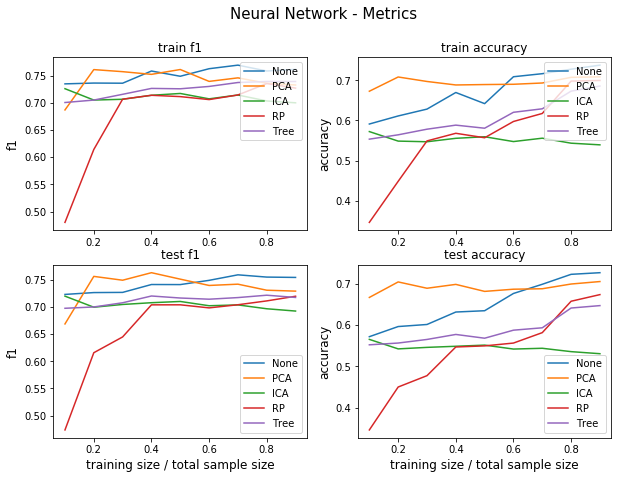

In [283]:
# #time
# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_figheight(7)
# fig.set_figwidth(15)
# fig.suptitle('Neural Network - Time',fontsize=20)
# for index, row in df_training_nn.iterrows():
#     label_str = index
#     ax1.plot(row,label=label_str)
#     ax1.legend(loc='upper left')
# ax1.set_xlabel("training size / total sample size",fontsize=15)
# ax1.set_ylabel("training time",fontsize=15)
# ax1.set_title("training time",fontsize = 20)

# for index, row in df_pred_nn.iterrows():
#     label_str = index
#     ax2.plot(row,label=label_str)
#     ax2.legend(loc='upper left')
# ax2.set_xlabel("training size / total sample size",fontsize=15)
# ax2.set_ylabel("prediction time",fontsize=15)
# ax2.set_title("prediction time",fontsize = 20)

# plt.show()
# fig.savefig("nn-time")

#train metrics
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(10)
fig.suptitle('Neural Network - Metrics',fontsize=15)
for index, row in df_f1_train_nn.iterrows():
    label_str = index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper right')
# ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("f1",fontsize=12)
ax1.set_title("train f1",fontsize = 12)

for index, row in df_accuracy_train_nn.iterrows():
    label_str =index 
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper right')
# ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("accuracy",fontsize=12)
ax2.set_title("train accuracy",fontsize = 12)



#test metrics
# fig.suptitle('Neural Network - Test Metrics',fontsize=20)
for index, row in df_f1_nn.iterrows():
    label_str = index
    ax3.plot(row,label=label_str)
    ax3.legend(loc='lower right')
ax3.set_xlabel("training size / total sample size",fontsize=12)
ax3.set_ylabel("f1",fontsize=12)
ax3.set_title("test f1",fontsize = 12)

for index, row in df_accuracy_nn.iterrows():
    label_str = index
    ax4.plot(row,label=label_str)
    ax4.legend(loc='lower right')
ax4.set_xlabel("training size / total sample size",fontsize=12)
ax4.set_ylabel("accuracy",fontsize=12)
ax4.set_title("test accuracy",fontsize = 12)



plt.show()
fig.savefig("nn-dr-metrics")

In [285]:
##step5

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import cross_validate
import timeit
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#working directory is the one with dataset
#clustering as dimension reduction
k_means_clustering = KMeans(n_clusters=4, random_state=2)
k_means_clustering.fit(df_wine_x)
label = np.reshape(k_means_clustering.labels_, (1599, 1))
df_wine_x_kmeans = np.append(df_wine_x, label,1)

gmm = mixture.GaussianMixture(n_components=4, covariance_type='full')
gmm.fit(df_wine_x)
gmm_label = gmm.predict(df_wine_x)
label = np.reshape(gmm_label, (1599, 1))
df_wine_x_gmm = np.append(df_wine_x, label,1)

x_all  = [df_wine_x,df_wine_x_kmeans,df_wine_x_gmm]
x_index = ['None','kmeans','em']

# https://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.neural_network import MLPClassifier

def all_tuples(beg, end, sep):
    value = np.arange(beg, end, sep)
    result = []
    for i in value:
        result.append((i,))
    return result



train_pct_sizes = np.linspace(.1, 0.9, 9)

#time
df_training_nn = pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_pred_nn = pd.DataFrame(columns=train_pct_sizes, index=x_index)
# print(df_training_bdtree)
#test_metrics
df_accuracy_nn = pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_precision_nn= pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_recall_nn= pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_f1_nn = pd.DataFrame(columns=train_pct_sizes, index=x_index)
#train_metrics
df_accuracy_train_nn = pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_precision_train_nn= pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_recall_train_nn= pd.DataFrame(columns=train_pct_sizes, index=x_index)
df_f1_train_nn = pd.DataFrame(columns=train_pct_sizes, index=x_index)

def cross_valid(clf, X_train, y_train):
    scoring = ["accuracy", "f1", "precision", "recall"]
    scores = cross_validate(clf, X_train, y_train, scoring=scoring, n_jobs=-1, cv=5, return_train_score=True)
    return scores

def train_test2(size,x):  
    _,y = load_xy2()
    x=x
    X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = size, random_state = 12345)
    return X_train, X_test, y_train, y_test

def classifier_time_metrics(clf, X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    #for train data
    y_pred_train = clf.predict(X_train)
    f1_train = f1_score(y_train,y_pred_train)
    accuracy_train = accuracy_score(y_train,y_pred_train)
    #The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
    precision_train = precision_score(y_train,y_pred_train) 
    recall_train = recall_score(y_train,y_pred_train)
    
    #for test data
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    #The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
    precision = precision_score(y_test,y_pred) 
    recall = recall_score(y_test,y_pred)

    
    return training_time, pred_time, accuracy,f1,precision, recall,accuracy_train, f1_train, precision_train, recall_train

def interpret_cross_valid_scores(scores):
#     train_metrics = ["train_accuracy", "train_f1", "train_precision", "train_recall"]
#     test_metrics = ["test_accuracy", "test_f1", "test_precision", "test_recall"]
    #test metrics
    accuracy = scores.get('test_accuracy')
    f1 = scores.get('test_f1')
    precision = scores.get('test_precision')
    recall = scores.get('test_recall')
    #train metrics
    accuracy_train = scores.get('train_accuracy')
    f1_train = scores.get('train_f1')
    precision_train = scores.get('train_precision')
    recall_train = scores.get('train_recall')
    return accuracy,f1,precision, recall
# accuracy_train, f1_train, precision_train, recall_train
    

count_k = 0
layer = (10,)

for x in x_all:
    clf = MLPClassifier(solver='sgd', activation = 'tanh', hidden_layer_sizes=layer, random_state=1)
    count_i = 0
    for i in train_pct_sizes:
        X_train, X_test, y_train, y_test = train_test2(i,x)
        
        clf = clf.fit(X_train,y_train)
        training_time, pred_time, accuracy,f1,precision, recall,accuracy_train, f1_train, precision_train, recall_train  \
        = classifier_time_metrics(clf, X_train, X_test, y_train, y_test )

        scores = cross_valid(clf, X_train, y_train)
        accuracy_array,f1_array,precision_array, recall_array = interpret_cross_valid_scores(scores)
        #add the test metrics to array            
        accuracy_array = np.append(accuracy_array,accuracy)
        f1_array = np.append(f1_array,f1)
        precision_array = np.append(precision_array,precision)
        recall_array = np.append(recall_array,recall)
        #make mean
        accuracy = np.mean(accuracy_array)
        f1 = np.mean(f1_array)
        precision = np.mean(precision_array)
        recall = np.mean(recall_array)
        
        #time metrics
        df_training_nn.iloc[count_k][count_i] = training_time
        df_pred_nn.iloc[count_k][count_i] = pred_time
        #test
        df_accuracy_nn.iloc[count_k][count_i] = accuracy
        df_precision_nn.iloc[count_k][count_i] = precision
        df_recall_nn.iloc[count_k][count_i] = recall
        df_f1_nn.iloc[count_k][count_i] = f1
        #train metrics
        df_accuracy_train_nn.iloc[count_k][count_i] = accuracy_train
        df_precision_train_nn.iloc[count_k][count_i] = precision_train
        df_recall_train_nn.iloc[count_k][count_i] = recall_train
        df_f1_train_nn.iloc[count_k][count_i] = f1_train
        
        count_i +=1
           
    count_k +=1


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\ne

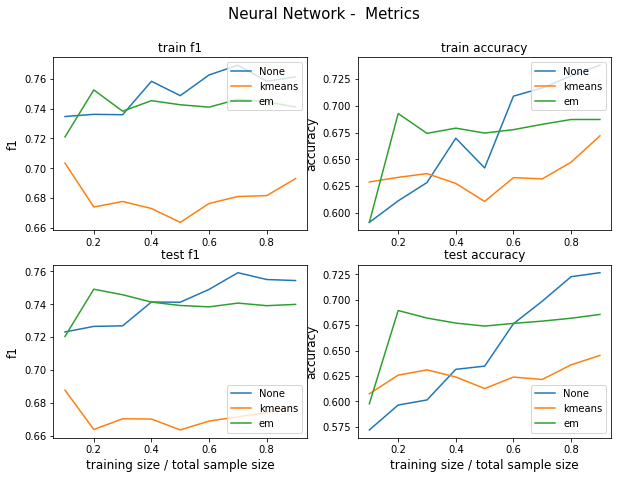

In [286]:

#train metrics
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(10)
fig.suptitle('Neural Network -  Metrics',fontsize=15)
for index, row in df_f1_train_nn.iterrows():
    label_str = index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper right')
# ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("f1",fontsize=12)
ax1.set_title("train f1",fontsize = 12)

for index, row in df_accuracy_train_nn.iterrows():
    label_str =index 
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper right')
# ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("accuracy",fontsize=12)
ax2.set_title("train accuracy",fontsize = 12)



#test metrics
for index, row in df_f1_nn.iterrows():
    label_str = index
    ax3.plot(row,label=label_str)
    ax3.legend(loc='lower right')
ax3.set_xlabel("training size / total sample size",fontsize=12)
ax3.set_ylabel("f1",fontsize=12)
ax3.set_title("test f1",fontsize = 12)

for index, row in df_accuracy_nn.iterrows():
    label_str = index
    ax4.plot(row,label=label_str)
    ax4.legend(loc='lower right')
ax4.set_xlabel("training size / total sample size",fontsize=12)
ax4.set_ylabel("accuracy",fontsize=12)
ax4.set_title("test accuracy",fontsize = 12)

fig.savefig("nn-cluster-metrics")